In [174]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import curve_fit
from ydata_profiling import ProfileReport
import scipy.optimize
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import pacf
from statsmodels.stats.diagnostic import normal_ad

import statsmodels.api as sm
import seaborn as sns


# Dane 

In [56]:
df_count = pd.read_csv('date_counts.csv')
print(df_count.columns)
count = df_count["Count"]
dates = df_count['Date']

n = len(count)
dates = pd.to_datetime(df_count['Date'])
n = len(count)
date0 = dates.iloc[0]
date_last = dates.iloc[-1]
timedelta = date_last - date0

print(n)
print("First day:", dates[0], "\nLast day:", dates[n-1], "\n Timedelta (this should be lenght of our data):", timedelta)
print("Maximum number of crimes:", max(count), "\nMinimum number of crimes:", min(count))

Index(['Date', 'Count'], dtype='object')
4017
First day: 2009-01-01 00:00:00 
Last day: 2019-12-31 00:00:00 
 Timedelta (this should be lenght of our data): 4016 days 00:00:00
Maximum number of crimes: 170 
Minimum number of crimes: 21


In [175]:
profile = ProfileReport(df_count, title = "Number of crimes")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0, 0.5, 'Liczba zgłoszonych przestępstw')

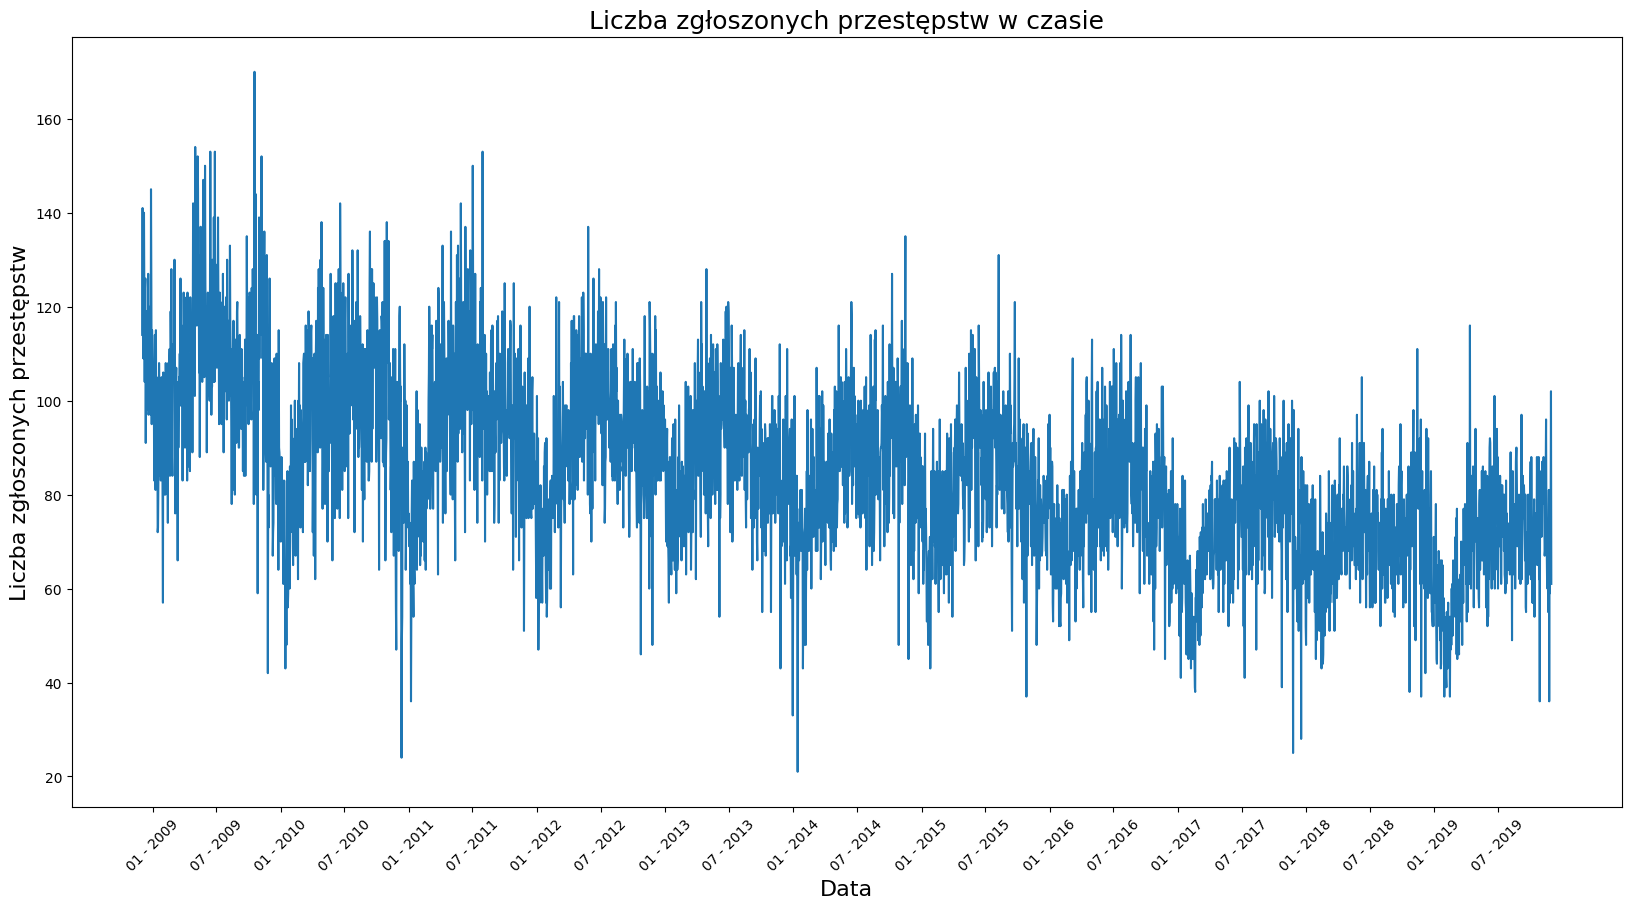

In [58]:
plt.figure(figsize=(20, 10))
dates = pd.to_datetime(df_count['Date'])
n = len(count)
date0 = dates.iloc[0]
date_last = dates.iloc[-1]
timedelta = date_last - date0


plt.plot(dates, count)
xticks = pd.date_range(start=date0, end=date_last, freq='6M')
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Liczba zgłoszonych przestępstw w czasie", fontsize=18)
plt.xlabel("Data", fontsize=16)
plt.ylabel("Liczba zgłoszonych przestępstw", fontsize=16)

Text(0.5, 0, '')

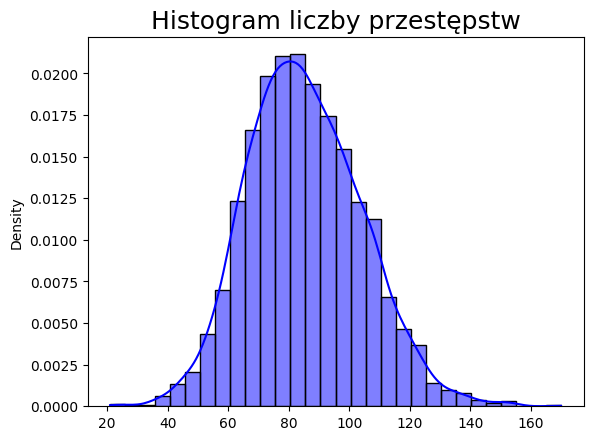

In [122]:
sns.histplot(count, bins=30, stat='density', kde=True, color='b', edgecolor='black', fill=True)
plt.title("Histogram liczby przestępstw", fontsize=18)
plt.xlabel("")

Obcięcie danych

In [59]:
n_cut = int(0.99*len(count))
count_99 = count[:n_cut]

# Test ADF - wejsciowe dane

In [60]:
result = adfuller(count_99)
print("Hipoteza zerowa: dane są niestacjonarne")
print("Hipoteza alternatywna: dane są stacjonwarne")


print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Liczba opóźnień:", result[2])
print("Liczba obserwacji użytych do testu:", result[3])
print("Wartości krytyczne:")
for key, value in result[4].items():
    print(f"   {key}: {value:.3f}")

if result[1] < 0.05:
    print("Odrzucamy hipotezę zerową (dane są stacjonarne).")
else:
    print("Nie można odrzucić hipotezy zerowej (dane są niestacjonarne).")

Hipoteza zerowa: dane są niestacjonarne
Hipoteza alternatywna: dane są stacjonwarne
ADF Statistic: -3.607846555344276
p-value: 0.0056127782078653
Liczba opóźnień: 29
Liczba obserwacji użytych do testu: 3946
Wartości krytyczne:
   1%: -3.432
   5%: -2.862
   10%: -2.567
Odrzucamy hipotezę zerową (dane są stacjonarne).


# Dekompozycja

In [61]:
def autocov_emp(X, h):
    n = len(X)
    h = abs(h)
    return 1/n*sum([(X[i] - np.mean(X))*(X[i + h] - np.mean(X)) for i in range(n - h)])

def autocorr_emp(X, h):
    return autocov_emp(X,h)/autocov_emp(X, 0)

def prosta_regresji(X, Y):
    b_1 = sum((X - np.mean(X))*(Y - np.mean(Y))) / sum((X- np.mean(X))**2)
    b_0 = np.mean(Y) - b_1*np.mean(X)
    return b_0, b_1

def fun(x, c,d, e, f):
    return c*(abs(np.sin(d*x + e))) + f


def fun2(x, c, d, e):
    return c*np.sin(d*x + e)


Transformacja Boxa-Coxa

count_transformed: [26.022 29.725 26.165 ... 19.955 19.091 22.096] 
lmbda_for_count: 0.5900137065735285
8.52076003225541 33.391081751225734


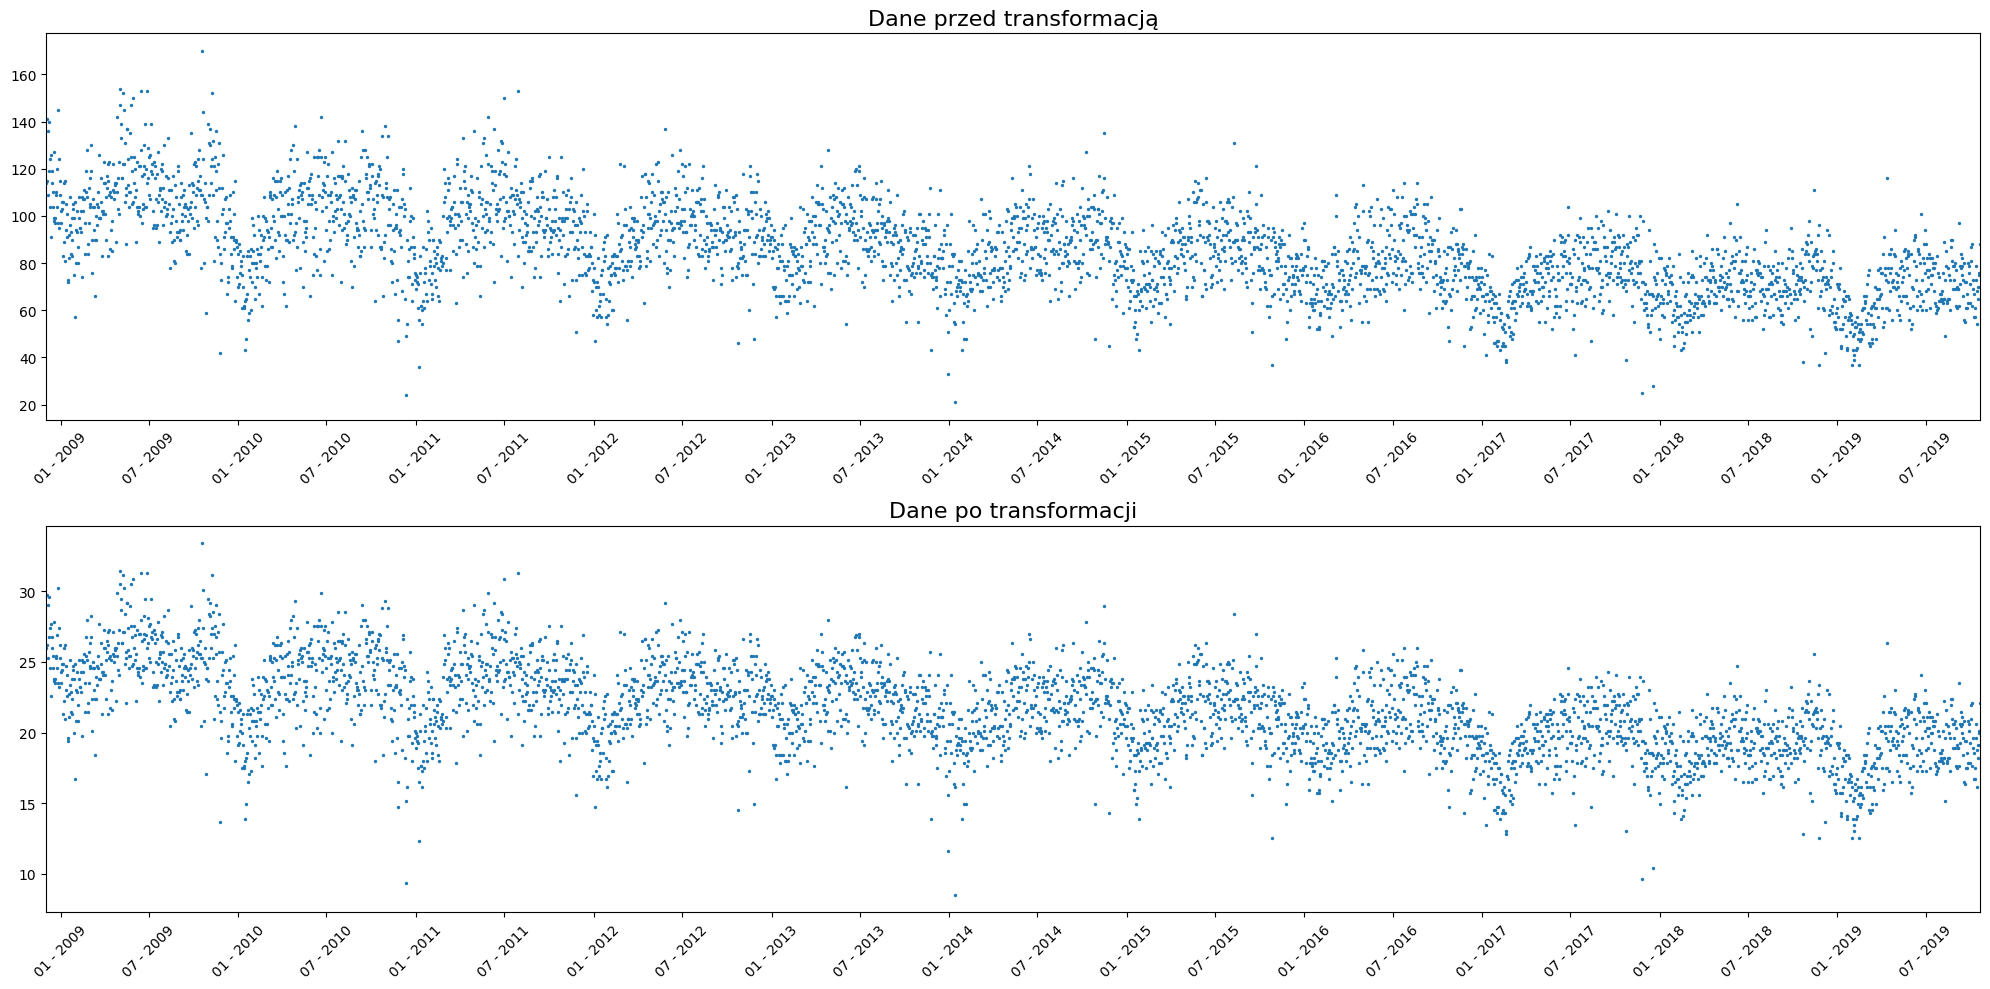

In [62]:
count_transformed, lmbda_for_count = stats.boxcox(count_99)
print(f'count_transformed: {count_transformed.round(3)} \nlmbda_for_count: {lmbda_for_count}')
print(min(count_transformed), max(count_transformed))
n = len(count_transformed)
X = np.arange(0, n, 1)

dates = pd.to_datetime(df_count['Date'][:n])
date0 = dates.iloc[0]
date_last = dates.iloc[-1]
timedelta = date_last - date0

plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.scatter(dates, count_99, s = 2)
xticks = pd.date_range(start=date0, end=date_last, freq='6M')
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane przed transformacją", fontsize = 16)
plt.xlim([dates.min(), dates.max()])

plt.subplot(2, 1, 2)
plt.scatter(dates, count_transformed, s = 2)
xticks = pd.date_range(start=date0, end=date_last, freq='6M')
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane po transformacji", fontsize = 16)
plt.xlim([dates.min(), dates.max()])
plt.tight_layout()

24.685457556377123 -0.001575422853271628
2.461466716049756
Okres: 373.88884873270985 3.4260439830592837


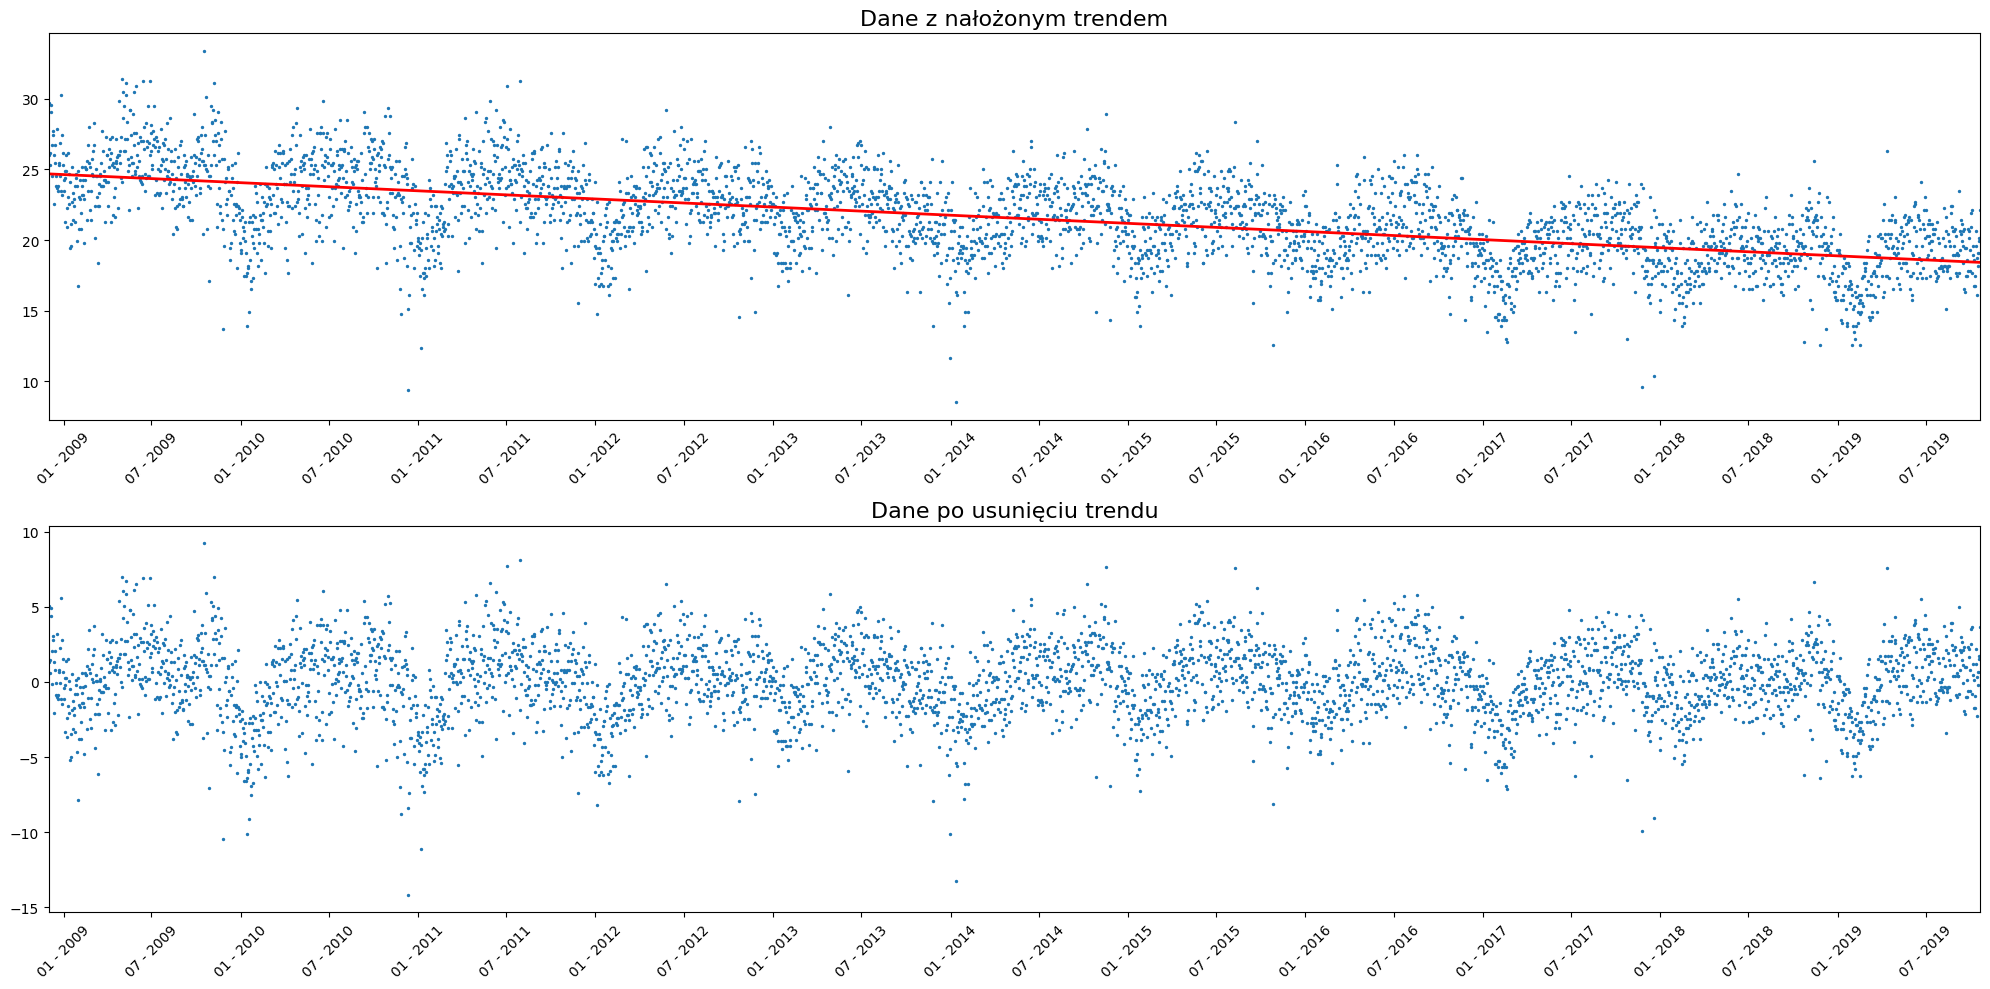

In [63]:
n = len(count_transformed)
X = np.arange(0, n, 1)
b_0, b_1 = prosta_regresji(X, count_transformed)
prosta = b_0 + b_1*X
count_bez_trendu = count_transformed - prosta
print(b_0, b_1)

plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.plot(dates, prosta, c = 'r', linewidth = 2)
plt.scatter(dates, count_transformed, s = 2)
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane z nałożonym trendem", fontsize = 16)
plt.xlim([dates.min(), dates.max()])
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.scatter(dates, count_bez_trendu, s = 2)
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane po usunięciu trendu", fontsize = 16)
plt.xlim([dates.min(), dates.max()])
plt.tight_layout()

plt.show()


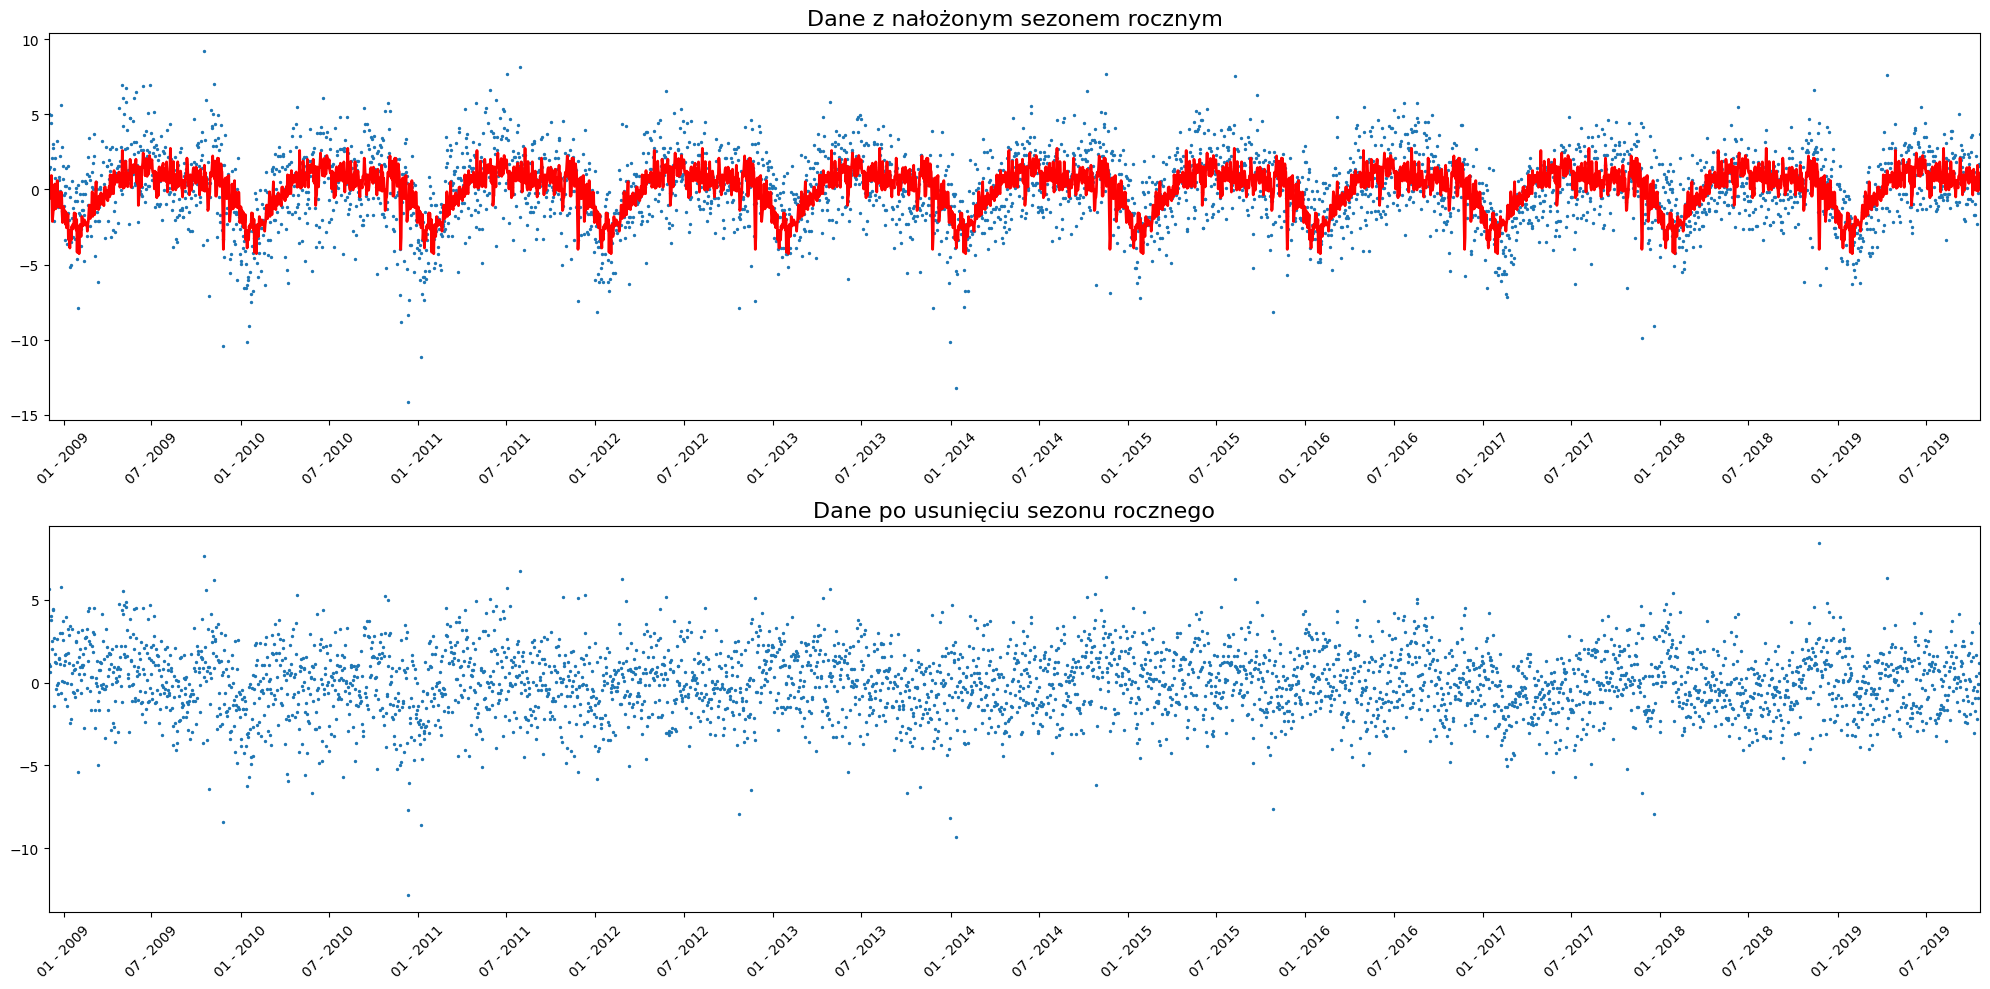

In [124]:
# Próba różnicowania
def wyznaczanie_sezonu_rocznego(X):

    sezon = np.zeros(365)
    for i in range(365):
        sezon[i] = np.mean(X[i::365])

    return sezon

sezon = wyznaczanie_sezonu_rocznego(count_bez_trendu)
sezonowosc2 = np.zeros(len(count_bez_trendu))
for i in range(len(count_bez_trendu)):
    sezonowosc2[i] = sezon[i%365]
count_bez_sezonu_2 = count_bez_trendu - sezonowosc2


plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.plot(dates, sezonowosc2, c = 'r', linewidth = 2)
plt.scatter(dates, count_bez_trendu, s = 2)
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane z nałożonym sezonem rocznym", fontsize = 16)
plt.xlim([dates.min(), dates.max()])
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.scatter(dates, count_bez_sezonu_2, s = 2)
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane po usunięciu sezonu rocznego", fontsize = 16)
plt.xlim([dates.min(), dates.max()])
plt.tight_layout()

plt.show()


In [65]:
dane_do_sprawdzenia = sezonowosc2[100:350]
i = np.argmin(dane_do_sprawdzenia)+100
j = np.argmin(sezonowosc2)
print(i, j)
print(dates[i], dates[j])#to jest ten skok w danych

327 62
2009-11-24 00:00:00 2009-03-04 00:00:00


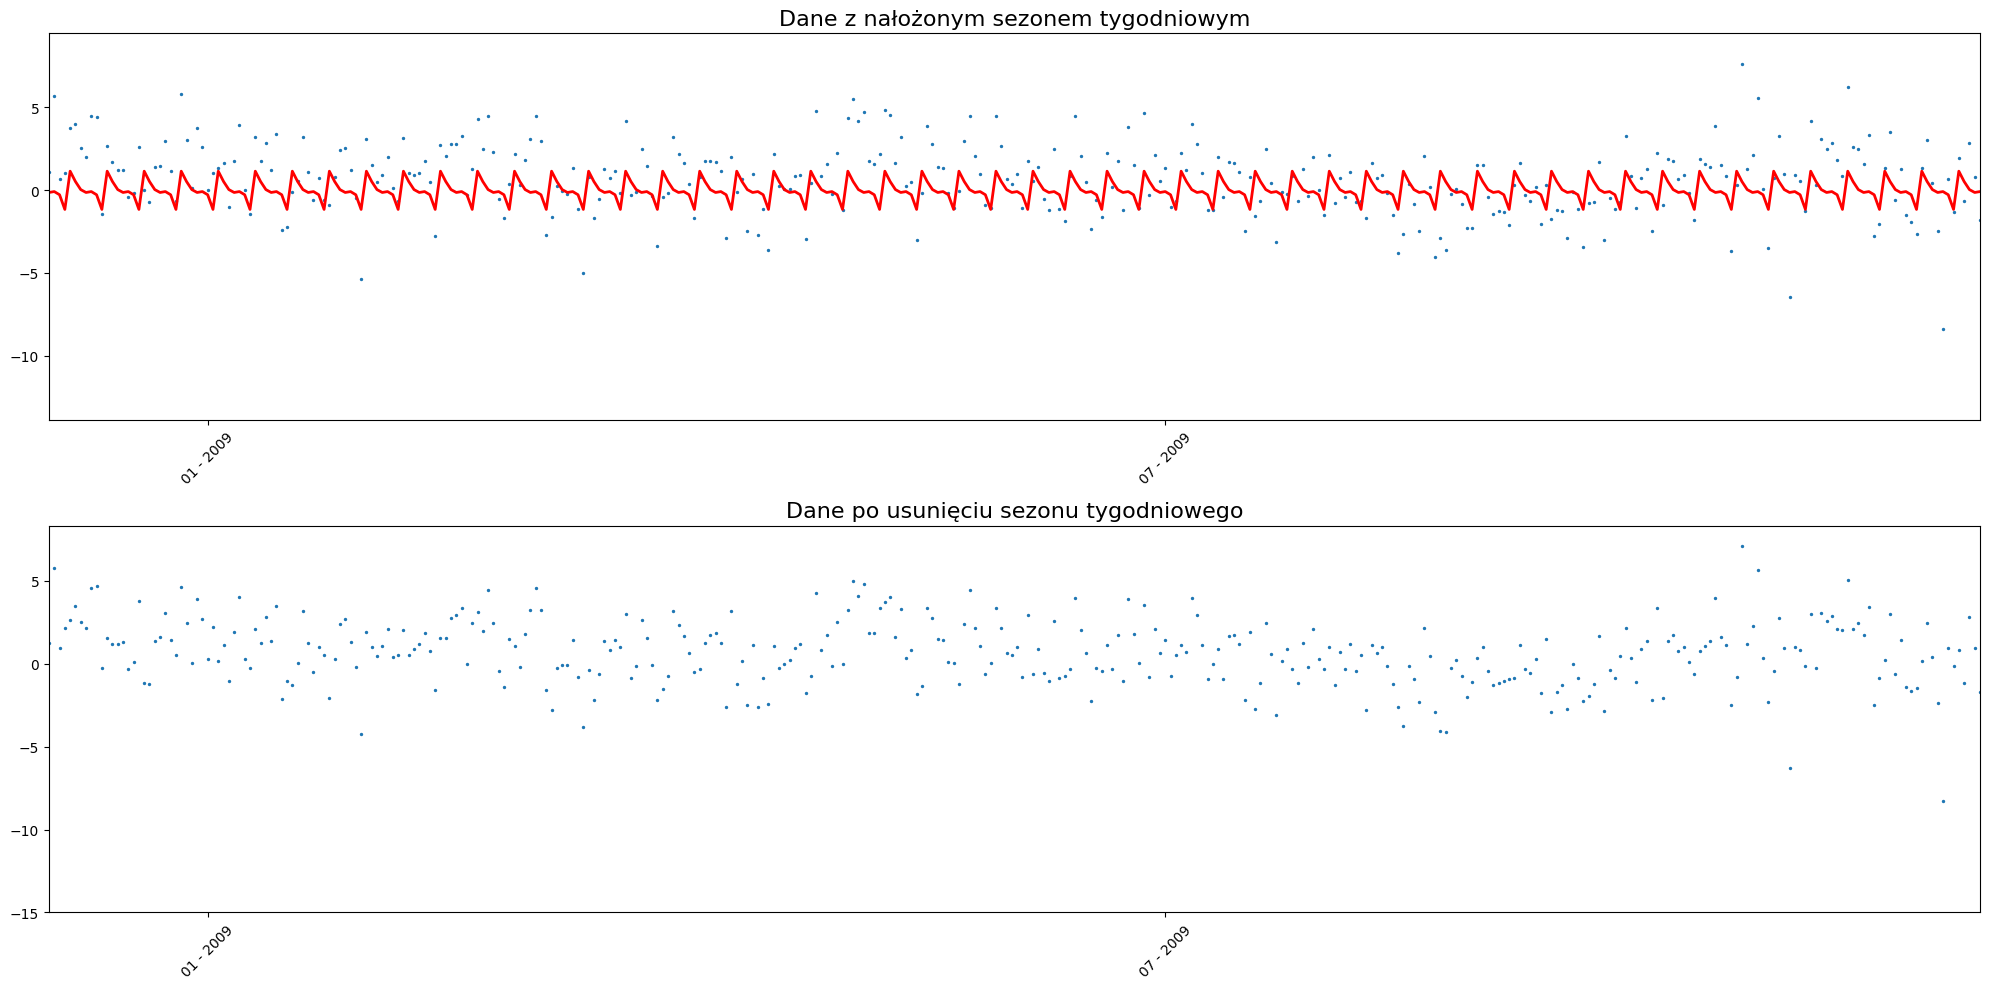

In [127]:
# Próba różnicowania
def wyznaczanie_sezonu_tygodniowego(X):

    sezon = np.zeros(7)
    for i in range(7):
        sezon[i] = np.mean(X[i::7])

    return sezon

sezon_tyg = wyznaczanie_sezonu_tygodniowego(count_bez_sezonu_2)
sezonowosc_tyg = np.zeros(len(count_bez_sezonu_2))
for i in range(len(count_bez_sezonu_2)):
    sezonowosc_tyg[i] = sezon_tyg[i%7]
count_bez_sezonu_tyg = count_bez_sezonu_2- sezonowosc_tyg


plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.plot(dates, sezonowosc_tyg, c = 'r', linewidth = 2)
plt.scatter(dates, count_bez_sezonu_2, s = 2)
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane z nałożonym sezonem tygodniowym", fontsize = 16)
plt.xlim([dates.min(), dates[365]])

plt.tight_layout()

plt.subplot(2, 1, 2)
plt.scatter(dates, count_bez_sezonu_tyg, s = 2)
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane po usunięciu sezonu tygodniowego", fontsize = 16)
plt.xlim([dates.min(), dates[365]])
plt.tight_layout()

plt.show()

Test ADF - dane po dekompozycji

In [68]:
result = adfuller(count_bez_sezonu_tyg)
print("Hipoteza zerowa: dane są niestacjonarne")
print("Hipoteza alternatywna: dane są stacjonwarne")


print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Liczba opóźnień:", result[2])
print("Liczba obserwacji użytych do testu:", result[3])
print("Wartości krytyczne:")
for key, value in result[4].items():
    print(f"   {key}: {value:.3f}")

if result[1] < 0.05:
    print("Odrzucamy hipotezę zerową (dane są stacjonarne).")
else:
    print("Nie można odrzucić hipotezy zerowej (dane są niestacjonarne).")

Hipoteza zerowa: dane są niestacjonarne
Hipoteza alternatywna: dane są stacjonwarne
ADF Statistic: -8.19769754019898
p-value: 7.372922384179741e-13
Liczba opóźnień: 29
Liczba obserwacji użytych do testu: 3946
Wartości krytyczne:
   1%: -3.432
   5%: -2.862
   10%: -2.567
Odrzucamy hipotezę zerową (dane są stacjonarne).


# ACF I PACF

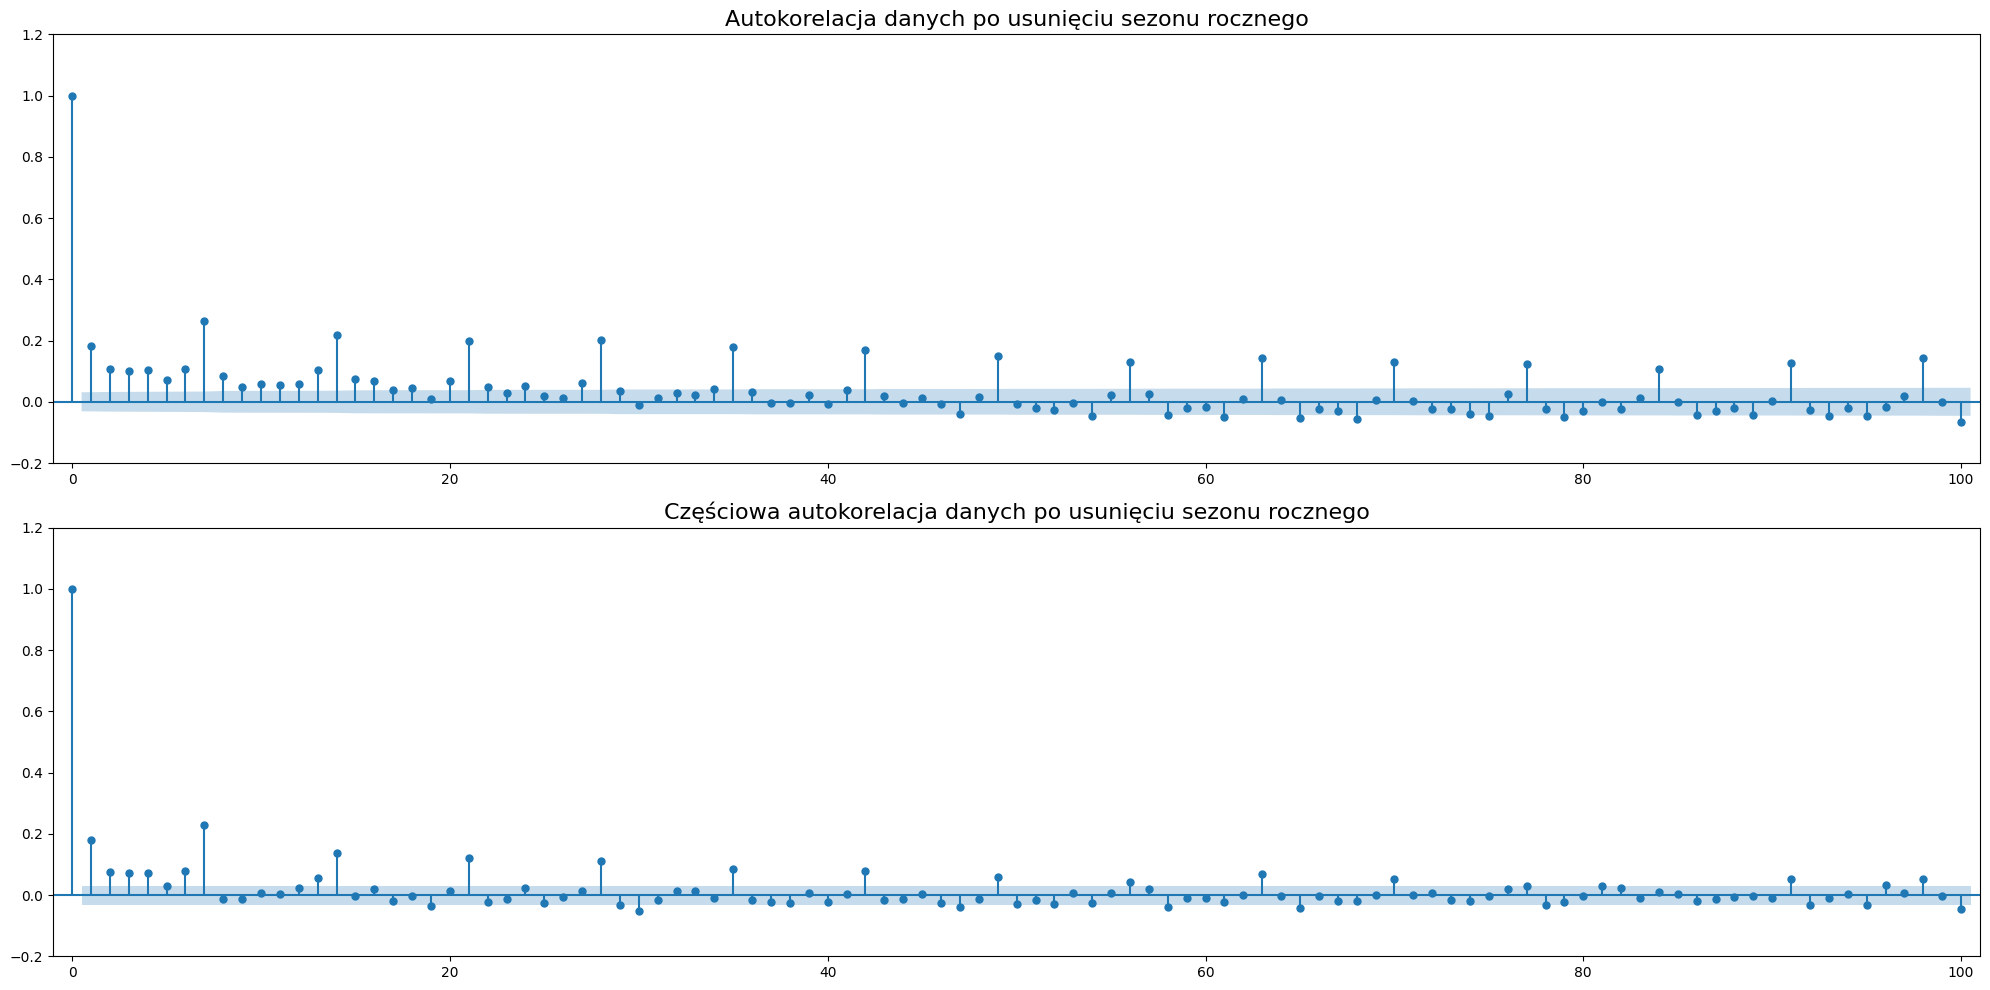

In [130]:
h = 100

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plot_acf(count_bez_sezonu_2, lags=min(h, len(count_99) - 1), adjusted=True, ax=plt.gca())
plt.title("Autokorelacja danych po usunięciu sezonu rocznego", fontsize=16
          )
plt.xlim([-1, 101])
plt.ylim([-0.2, 1.2])
# Partial Autocorrelation Function
plt.subplot(2, 1, 2)
plot_pacf(count_bez_sezonu_2, lags=min(h, len(count_99) - 1), method='ywm', ax=plt.gca())
plt.title("Częściowa autokorelacja danych po usunięciu sezonu rocznego", fontsize=16)
plt.xlim([-1, 101])
plt.ylim([-0.2, 1.2])

plt.tight_layout()
plt.show()

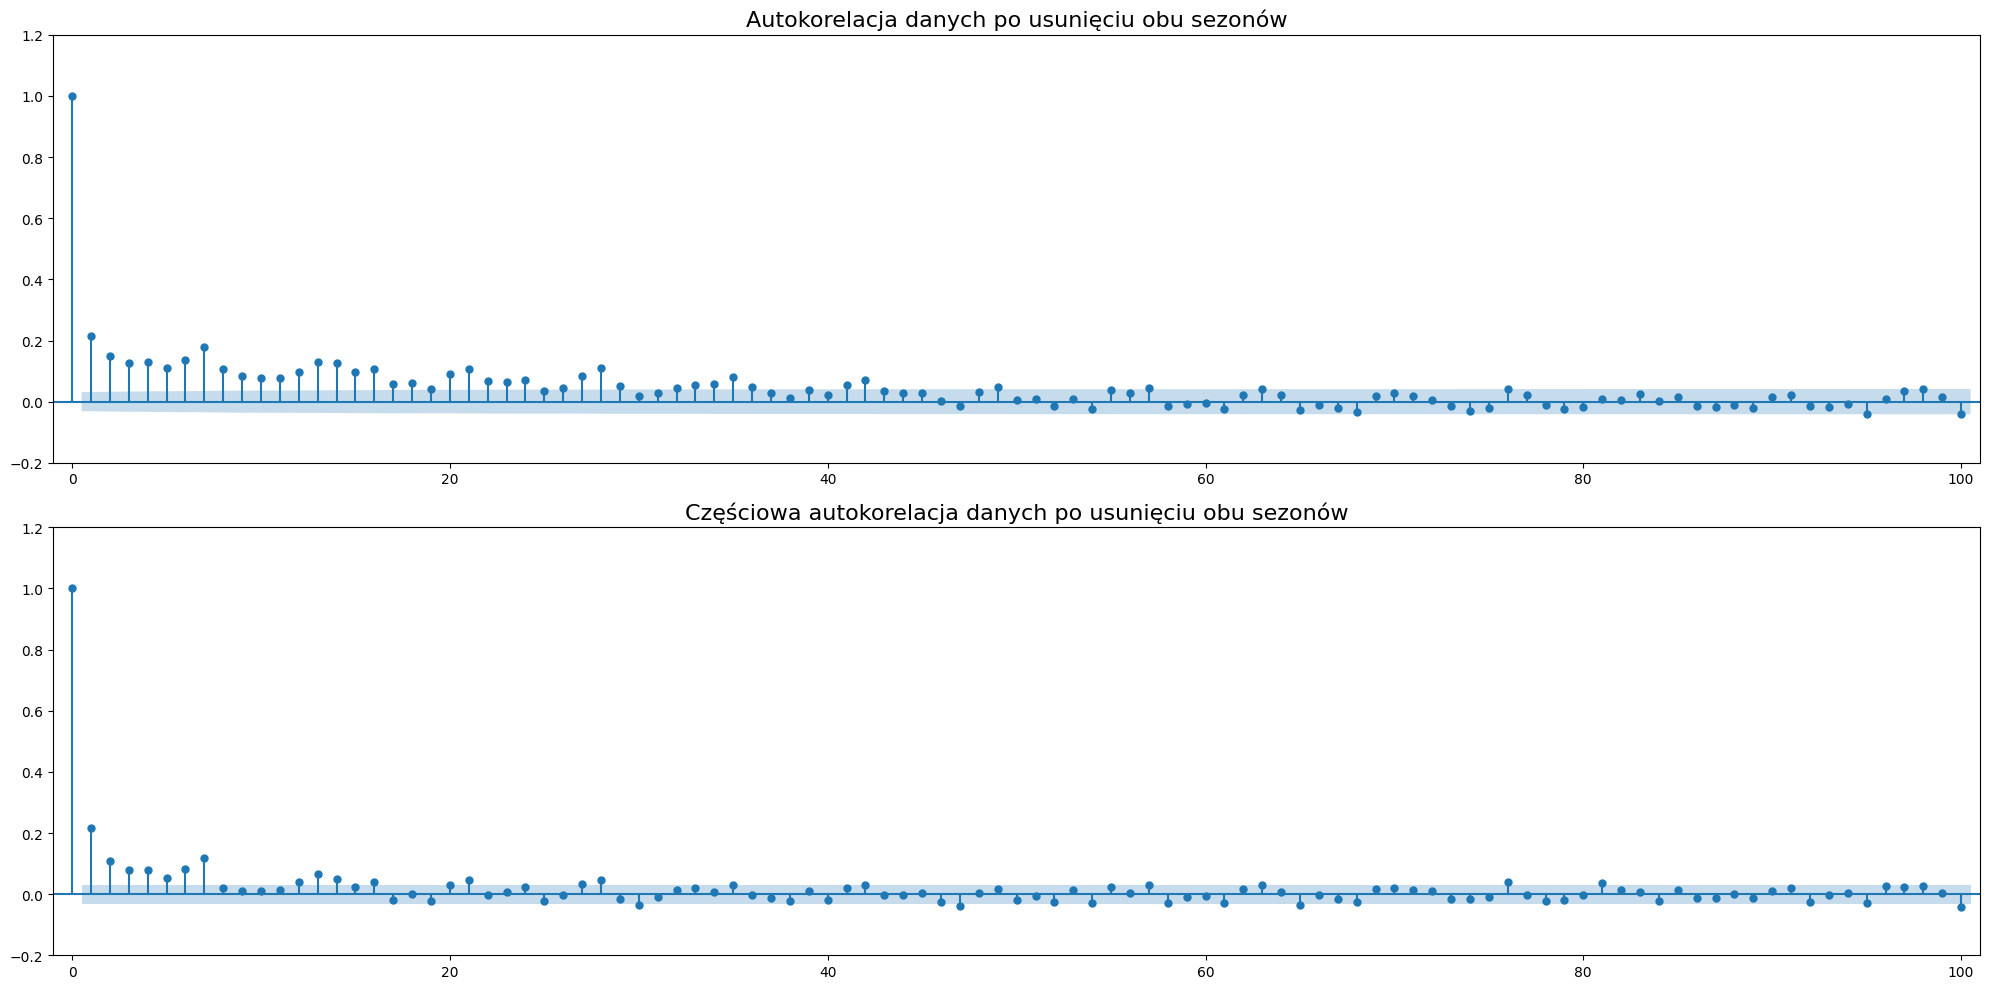

In [129]:
h = 100

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plot_acf(count_bez_sezonu_tyg, lags=min(h, len(count_99) - 1), adjusted=True, ax=plt.gca())
plt.title("Autokorelacja danych po usunięciu obu sezonów", fontsize=16
          )
plt.xlim([-1, 101])
plt.ylim([-0.2, 1.2])
# Partial Autocorrelation Function
plt.subplot(2, 1, 2)
plot_pacf(count_bez_sezonu_tyg, lags=min(h, len(count_99) - 1), method='ywm', ax=plt.gca())
plt.title("Częściowa autokorelacja danych po usunięciu obu sezonów", fontsize=16)
plt.xlim([-1, 101])
plt.ylim([-0.2, 1.2])

plt.tight_layout()
plt.show()

In [69]:
def autocov(X, h):
    n = len(X)
    result = 0
    X_mean = np.mean(X)
    h = np.abs(h)
    for i in range(n - h):
        result += (X[i] - X_mean)*(X[i +h] - X_mean)
    
    result /= n
    return result    

def autocorr(X, h):
    return (autocov(X, h)/ autocov(X,0))  

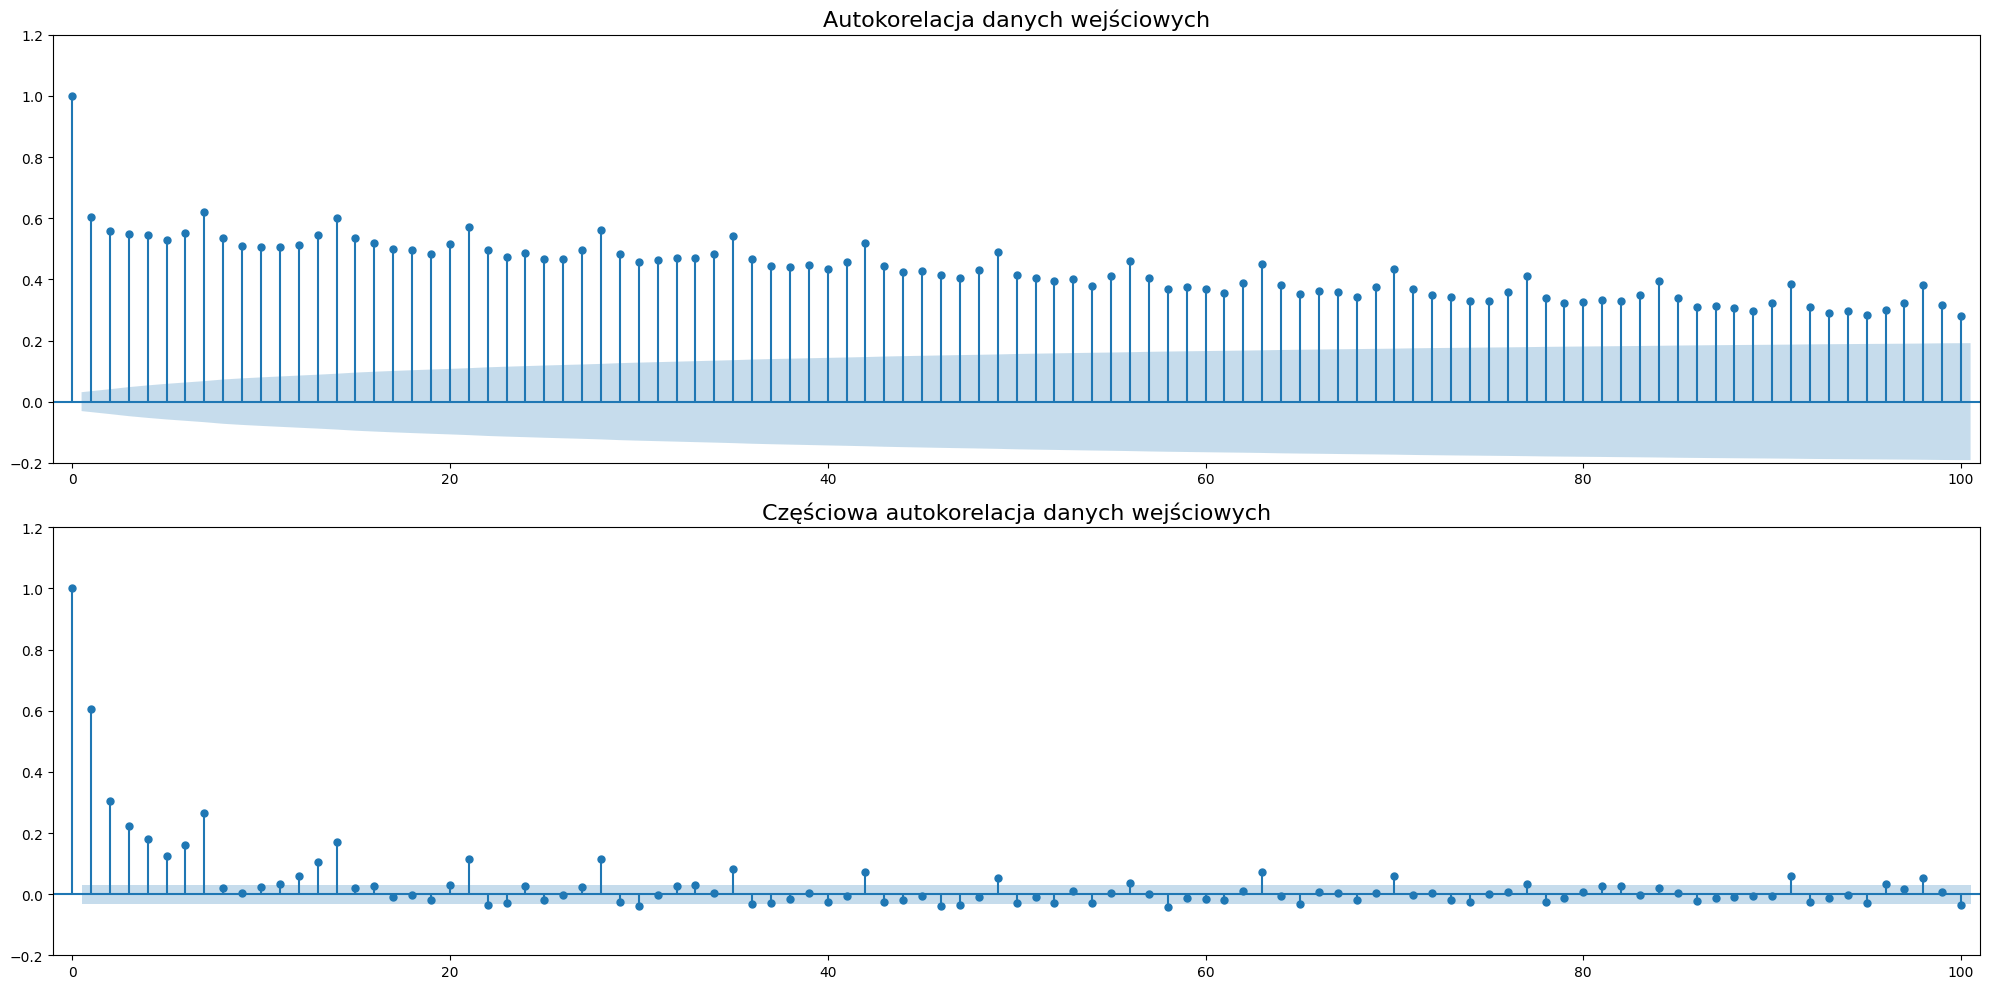

In [131]:
h = 100

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plot_acf(count, lags=min(h, len(count) - 1), adjusted=True, ax=plt.gca())
plt.title("Autokorelacja danych wejściowych", fontsize=16
          )
plt.xlim([-1, 101])
plt.ylim([-0.2, 1.2])
# Partial Autocorrelation Function
plt.subplot(2, 1, 2)
plot_pacf(count, lags=min(h, len(count) - 1), method='ywm', ax=plt.gca())
plt.title("Częściowa autokorelacja danych wejściowych", fontsize=16)
plt.xlim([-1, 101])
plt.ylim([-0.2, 1.2])

plt.tight_layout()
plt.show()

# MODELOWANIE DANYCH PRZY POMOCY ARMA

In [72]:
df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 3
max_q = 3

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(count_bez_sezonu_tyg, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

In [73]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
7,2,1,16100.515796,16131.955954,16111.663921
5,1,2,16100.889989,16132.330147,16112.038114
8,2,2,16102.467873,16140.196062,16115.845623
4,1,1,16117.839070,16142.991196,16126.757570
6,2,0,16246.124863,16271.276989,16255.043363


In [74]:
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
7,2,1,16100.515796,16131.955954,16111.663921
5,1,2,16100.889989,16132.330147,16112.038114
8,2,2,16102.467873,16140.196062,16115.845623
4,1,1,16117.839070,16142.991196,16126.757570
6,2,0,16246.124863,16271.276989,16255.043363


In [75]:
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
7,2,1,16100.515796,16131.955954,16111.663921
5,1,2,16100.889989,16132.330147,16112.038114
8,2,2,16102.467873,16140.196062,16115.845623
4,1,1,16117.839070,16142.991196,16126.757570
6,2,0,16246.124863,16271.276989,16255.043363


Bierzemy ARMA(2,1)

In [76]:



# Dopasowanie modelu ARMA(2,1)
model = ARIMA(count_bez_sezonu_tyg, order=(2, 0,1))  # ARMA(p=2, d=0, q=1)
fitted_model = model.fit()

# Wyświetlenie współczynników modelu
print(fitted_model.summary())

# Pobranie parametrów
ar_params = fitted_model.arparams  # Współczynniki AR
ma_params = fitted_model.maparams  # Współczynniki MA
residua = fitted_model.resid
print(f"Współczynniki AR: {ar_params}")
print(f"Współczynniki MA: {ma_params}")
print(f"Residua: {residua}")


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3976
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -8045.258
Date:                Tue, 28 Jan 2025   AIC                          16100.516
Time:                        10:59:33   BIC                          16131.956
Sample:                             0   HQIC                         16111.664
                               - 3976                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0129      0.098      0.132      0.895      -0.179       0.204
ar.L1          1.0499      0.020     51.241      0.000       1.010       1.090
ar.L2         -0.0800      0.017     -4.806      0.0

# Przedzialy ufności PACF i ACF

In [133]:
def ARMA_21_generator(n, sigma_2, phi_1, phi_2, theta_1):
    Z_t = np.random.normal(0, sigma_2, n+2)

    X_t = [1 , 1]
    for t in range(n):
        X = phi_1*X_t[t+1] + phi_2*X_t[t] + Z_t[t +2] +  theta_1 *Z_t[ t+1]
        X_t.append(X)

    return X_t[2:]

In [134]:
phi_1, phi_2 = ar_params
theta_1 = ma_params
sigma_2 = 3.35

n = len(count_bez_sezonu_tyg)
h = 50
N = 100
X_t_vector = [ARMA_21_generator(n, sigma_2, phi_1, phi_2, theta_1) for _ in range(N)]

ACF

In [135]:
A_empiric_acf = []
for X_t in X_t_vector:
    empiric_autocorr = [autocorr(X_t, h_value) for h_value in range(h)]

    A_empiric_acf.append(empiric_autocorr)  


In [136]:
empiric_quantile_005_values = []
empiric_quantile_095_values = []

for i in range(len(A_empiric_acf[0])):
    A_empiric_column = [A_empiric_acf[j][i] for j in range(len(X_t_vector))]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values.append(quantile_empiric_005)
    empiric_quantile_095_values.append(quantile_empiric_095)




In [137]:
cout_acf = [autocorr(count_bez_sezonu_tyg, h_value) for h_value in range(h)]

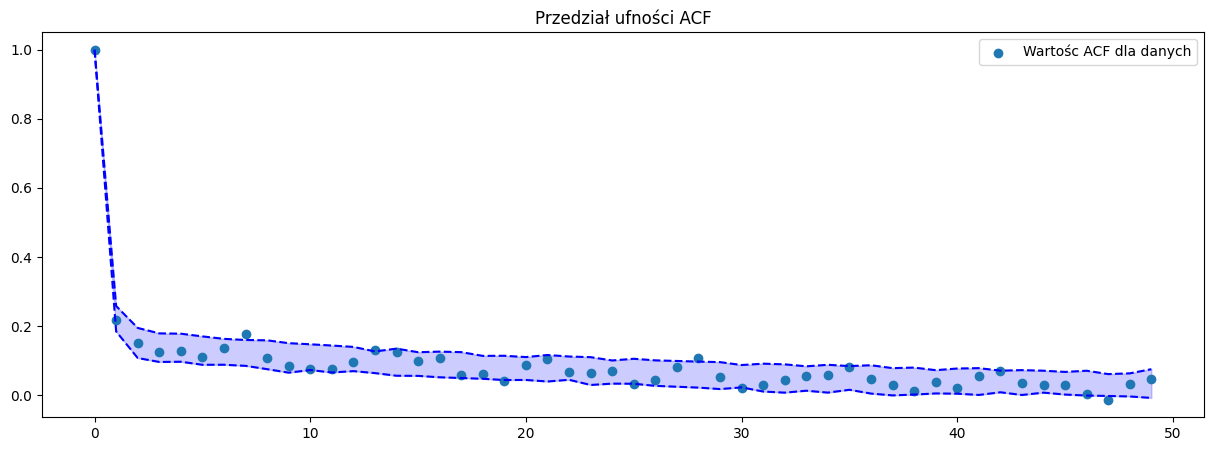

In [140]:
h_values = np.arange(0, h, 1)
plt.figure(figsize = ((15,5)))
plt.plot(h_values, empiric_quantile_005_values, linestyle = "--", color = "blue")
plt.plot(h_values, empiric_quantile_095_values, linestyle = "--", color = "blue")

plt.fill_between(h_values, empiric_quantile_005_values, empiric_quantile_095_values, 
                 color="blue", alpha=0.2)
plt.scatter(h_values, cout_acf, label= "Wartośc ACF dla danych")

plt.title("Przedział ufności ACF")
plt.legend()
plt.show()


PACF

In [83]:
A_empiric_pacf = []
for X_t in X_t_vector:
    empiric_pacf = pacf(X_t, 50) 

    A_empiric_pacf.append(empiric_pacf)   

In [84]:
empiric_quantile_005_values_pacf = []
empiric_quantile_095_values_pacf = []

for i in range(len(A_empiric_pacf[0])):
    A_empiric_column = [A_empiric_pacf[j][i] for j in range(len(X_t_vector))]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_pacf.append(quantile_empiric_005)
    empiric_quantile_095_values_pacf.append(quantile_empiric_095)

In [85]:
count_pacf = pacf(count_bez_sezonu_tyg, 50)

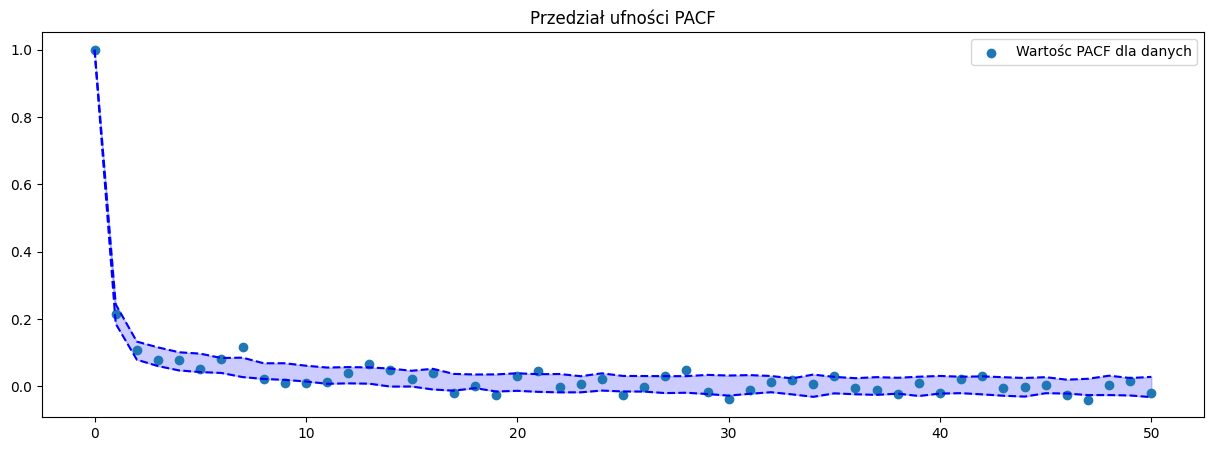

In [141]:
h_values = np.arange(0, h+1, 1)
plt.figure(figsize = (15,5))
plt.plot(h_values, empiric_quantile_005_values_pacf, linestyle = "--", color = "blue")
plt.plot(h_values, empiric_quantile_095_values_pacf, linestyle = "--", color = "blue")

plt.fill_between(h_values, empiric_quantile_005_values_pacf, empiric_quantile_095_values_pacf, 
                 color="blue", alpha=0.2)
plt.scatter(h_values, count_pacf, label= "Wartośc PACF dla danych")

plt.title("Przedział ufności PACF")
plt.legend()
plt.show()

# Linie kwantylowe z trajektorią

In [143]:
empiric_quantile_005_values_trajectory = []
empiric_quantile_095_values_trajectory = []

for i in range(len(X_t_vector[0])):
    A_empiric_column = [X_t_vector[j][i] for j in range(N)]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_trajectory.append(quantile_empiric_005)
    empiric_quantile_095_values_trajectory.append(quantile_empiric_095)

<Figure size 2000x500 with 0 Axes>

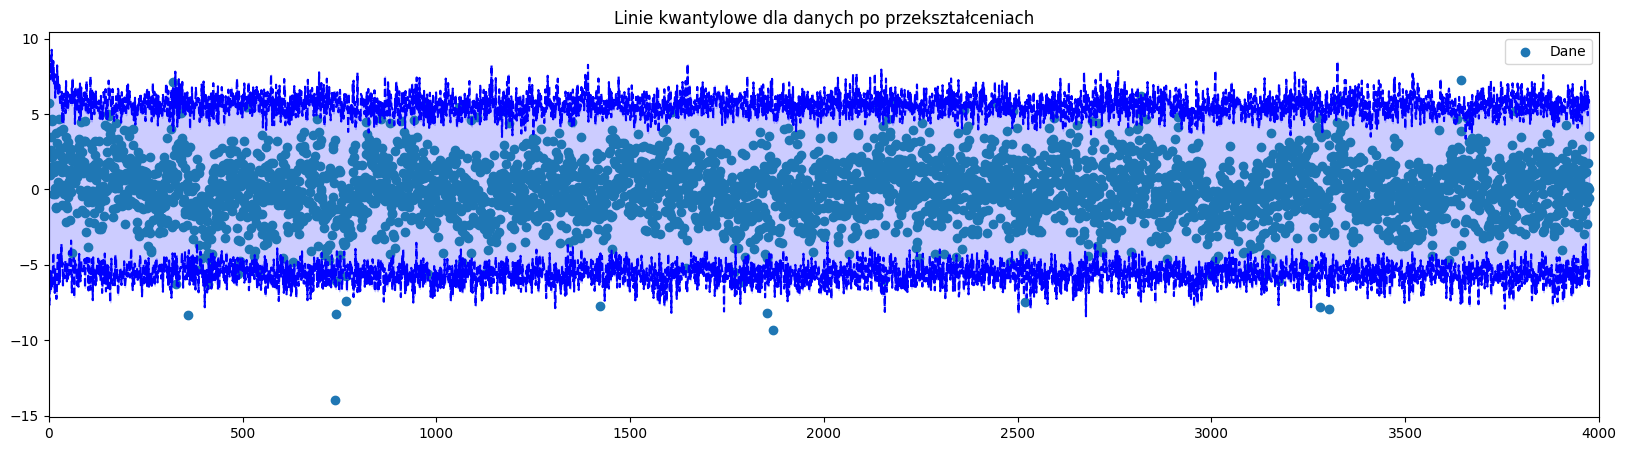

In [144]:
n_values = np.arange(0, len(count_99), 1)
plt.figure(figsize = (20, 5))
plt.figure(figsize = (20, 5))
plt.plot(n_values, empiric_quantile_005_values_trajectory, linestyle = "--", color = "blue")
plt.plot(n_values, empiric_quantile_095_values_trajectory, linestyle = "--", color = "blue")

plt.fill_between(n_values, empiric_quantile_005_values_trajectory, empiric_quantile_095_values_trajectory, 
                 color="blue", alpha=0.2)

plt.scatter(n_values, count_bez_sezonu_tyg, label= "Dane")

plt.title("Linie kwantylowe dla danych po przekształceniach")
plt.xlim((0,4000))
plt.legend()
plt.show()

# Linie kwantylowe z trajektorią (nałożony trend i sezonowość)

In [107]:
empiric_quantile_005_values_trajectory_z_dodatkami = empiric_quantile_005_values_trajectory + sezonowosc2 + sezonowosc_tyg + prosta
empiric_quantile_095_values_trajectory_z_dodatkami = empiric_quantile_095_values_trajectory + sezonowosc2 + sezonowosc_tyg + prosta

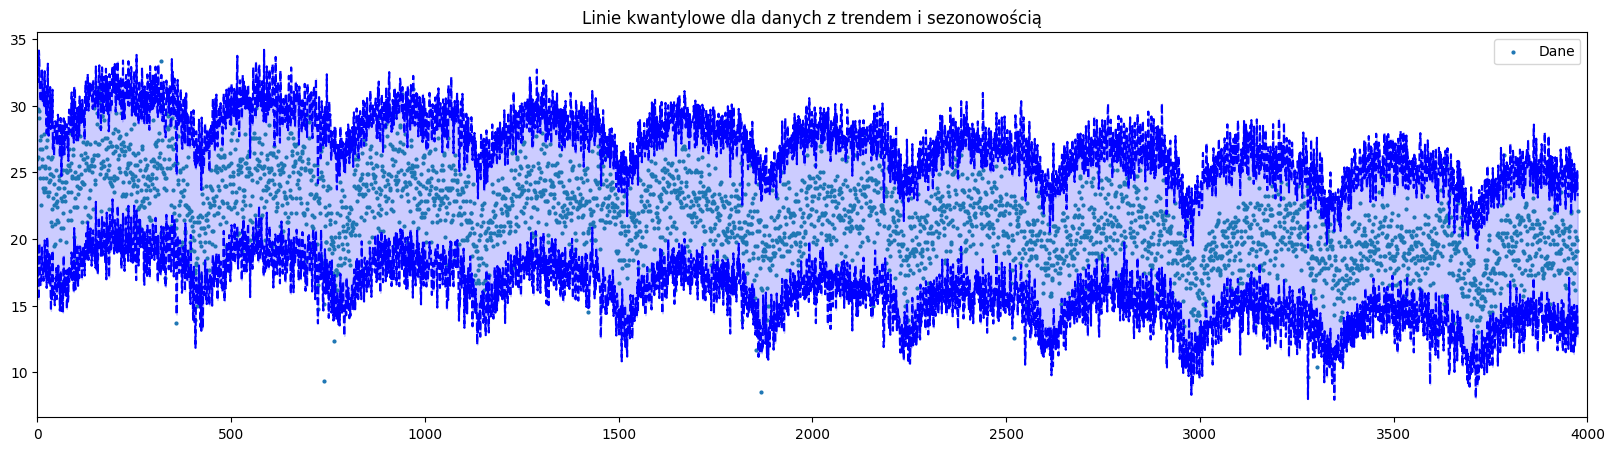

In [113]:
n_values = np.arange(0, len(count_99), 1)
plt.figure(figsize = (20, 5))
plt.plot(n_values, empiric_quantile_005_values_trajectory_z_dodatkami, linestyle = "--", color = "blue")
plt.plot(n_values, empiric_quantile_095_values_trajectory_z_dodatkami, linestyle = "--", color = "blue")

plt.fill_between(n_values, empiric_quantile_005_values_trajectory_z_dodatkami, empiric_quantile_095_values_trajectory_z_dodatkami, 
                 color="blue", alpha=0.2)

plt.scatter(n_values, count_transformed, s = 4, label= "Dane")

plt.title("Linie kwantylowe dla danych z trendem i sezonowością")
plt.xlim((0,4000))
plt.legend()
plt.show()

# Predykcja danych

In [146]:
n = len(count)
X_t_vector = [ARMA_21_generator(n, sigma_2, phi_1, phi_2, theta_1) for _ in range(N)]
sezonowosc_roczna_n = np.zeros(n)
sezonowosc_tyg_n = np.zeros(n)

for i in range(n):
    sezonowosc_tyg_n[i] = sezon_tyg[i%7]

for i in range(n):
    sezonowosc_roczna_n[i] = sezon[i%365]

prosta_n = b_0 + b_1*np.arange(0, n, 1)

In [147]:
empiric_quantile_005_values_trajectory = []
empiric_quantile_095_values_trajectory = []

for i in range(len(X_t_vector[0])):
    A_empiric_column = [X_t_vector[j][i] for j in range(N)]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_trajectory.append(quantile_empiric_005)
    empiric_quantile_095_values_trajectory.append(quantile_empiric_095)

In [148]:
empiric_quantile_005_values_trajectory_z_dodatkami = empiric_quantile_005_values_trajectory + sezonowosc_roczna_n + sezonowosc_tyg_n+ prosta_n
empiric_quantile_095_values_trajectory_z_dodatkami = empiric_quantile_095_values_trajectory + sezonowosc_roczna_n + sezonowosc_tyg_n+ prosta_n

In [149]:
def inverse_box_cox(y_transformed, lamb):
    if lamb == 0:
        return np.exp(y_transformed)
    else:
        return (lamb * y_transformed + 1)**(1 / lamb)

quantile_005_inv_box_cox = inverse_box_cox(np.array(empiric_quantile_005_values_trajectory_z_dodatkami), lmbda_for_count)
quantile_095_inv_box_cox = inverse_box_cox(np.array(empiric_quantile_095_values_trajectory_z_dodatkami), lmbda_for_count)



In [150]:
predict = model_fit.predict(start=0, end=4016, dynamic=False, information_set='predicted', signal_only=False,) 
predict_z_dodatkami = predict + sezonowosc_roczna_n + sezonowosc_tyg_n + prosta_n
predict_inv = inverse_box_cox(predict_z_dodatkami, lmbda_for_count)


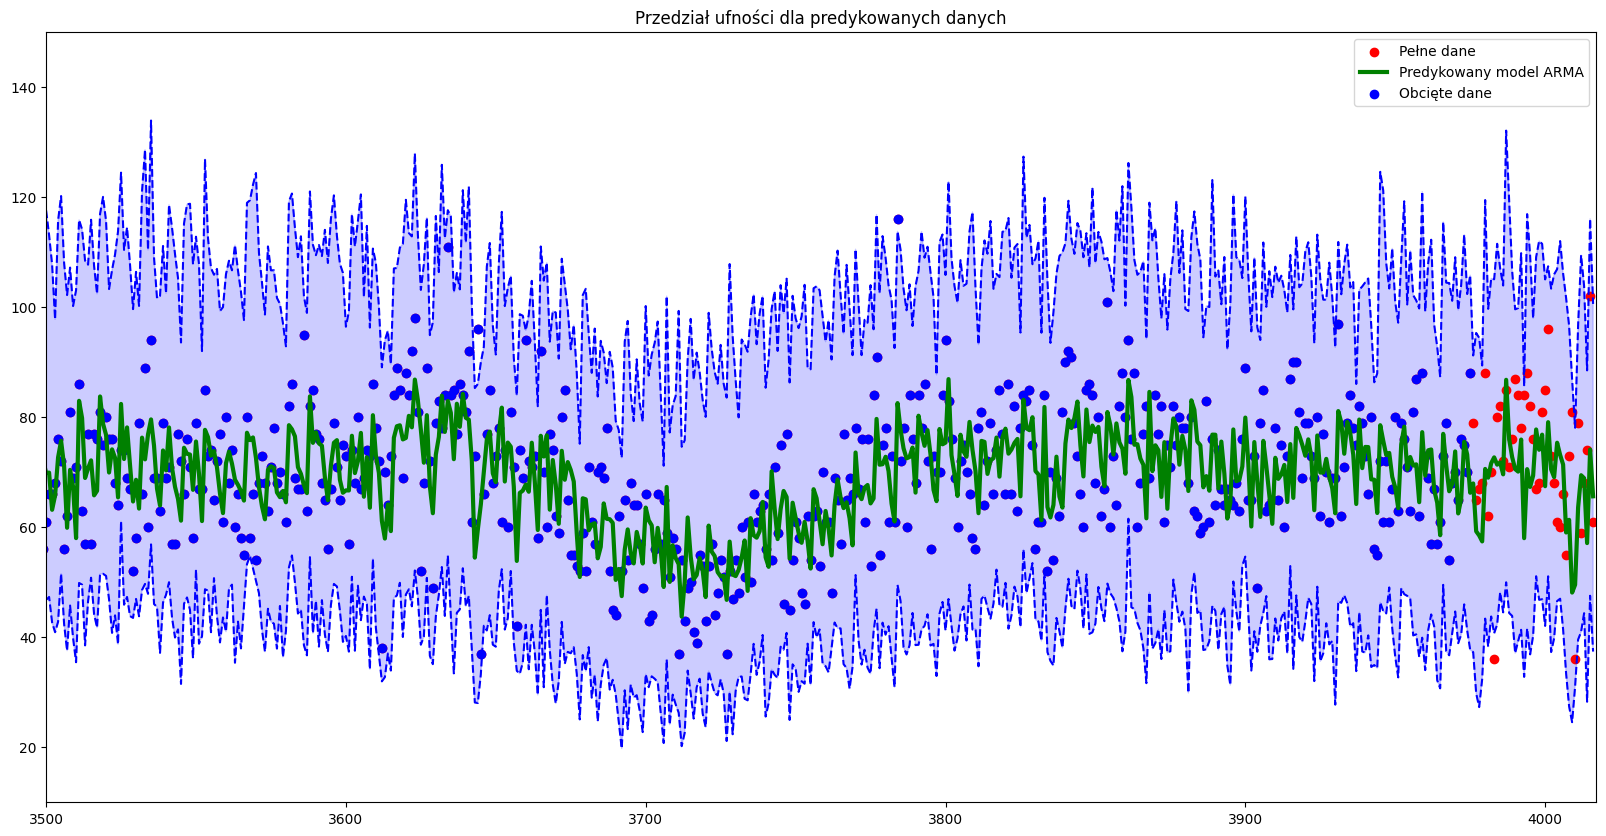

In [152]:
n_values = np.arange(0, n, 1)
plt.figure(figsize = (20, 10))
plt.plot(n_values, quantile_005_inv_box_cox, linestyle = "--", color = "blue")
plt.plot(n_values, quantile_095_inv_box_cox, linestyle = "--", color = "blue")

plt.fill_between(n_values, quantile_005_inv_box_cox, quantile_095_inv_box_cox, 
                 color="blue", alpha=0.2)

n_cut_values = np.arange(0, n_cut, 1)
plt.scatter(n_values, count, color = "red", label= "Pełne dane")
plt.plot(predict_inv, color = "green", linewidth = 3, label = "Predykowany model ARMA")
plt.scatter(n_cut_values, count_99, color = "blue", label= "Obcięte dane")

plt.title("Przedział ufności dla predykowanych danych")
plt.legend()
plt.xlim([3500, 4017])
plt.ylim([10,150])
plt.show()

# RESIDUA

Text(0.5, 1.0, 'Residua')

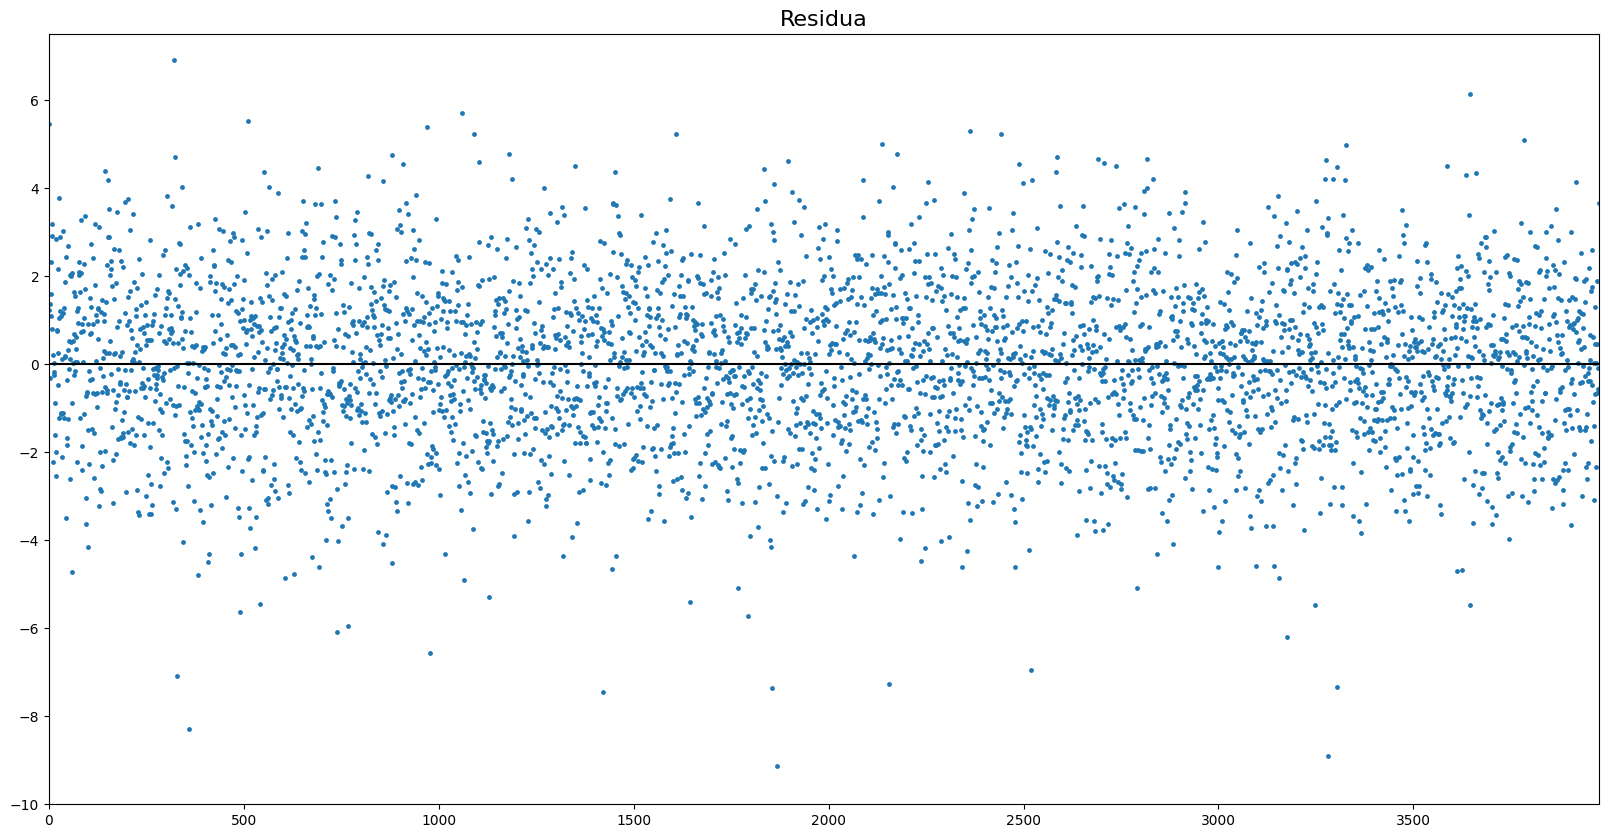

In [160]:
n_residua = len(residua)
plt.figure(figsize = (20, 10))
n_residua_values = np.arange(0, n_residua, 1)
plt.scatter(n_residua_values, residua, s= 6)
plt.axhline(y = 0, c = "k")
plt.xlim([0, n_residua])
plt.ylim([-10,7.5])
plt.title("Residua", fontsize = 16)



In [98]:
#Ttest
t_statistic, p_value = stats.ttest_1samp(residua, 0)

print("Statystyka t:", t_statistic)
print("Wartość p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Odrzucamy hipotezę zerową - średnia residułów znacząco różni się od 0.")
else:
    print("Nie odrzucamy hipotezy zerowej - średnia residułów nie różni się znacząco od 0.")

Statystyka t: -0.1585739974378012
Wartość p: 0.8740125719642808
Nie odrzucamy hipotezy zerowej - średnia residułów nie różni się znacząco od 0.


In [99]:
#Levene’s Test

group1 = residua[:1000]
group2 = residua[2000:]



statistic, p_value = stats.levene(group1, group2, center='median')


print("Statystyka testu Levene'a:", statistic)
print("Wartość p:", p_value)

alpha = 0.1
if p_value < alpha:
    print("Odrzucamy hipotezę zerową - wariancje różnią się istotnie.")
else:
    print("Nie odrzucamy hipotezy zerowej - nie ma dowodów na różnice w wariancjach.")

Statystyka testu Levene'a: 4.820176756408972
Wartość p: 0.028205457227569335
Odrzucamy hipotezę zerową - wariancje różnią się istotnie.


In [100]:
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(residua)


print("Statystyka testu ARCH:", arch_test[0])
print("Wartość p:", arch_test[1])
print("Liczba opóźnień:", arch_test[2])

alpha = 0.05
if arch_test[1] < alpha:
    print("Odrzucamy hipotezę zerową - występuje heteroskedastyczność warunkowa.")
else:
    print("Nie odrzucamy hipotezy zerowej - brak dowodów na heteroskedastyczność warunkową.")

Statystyka testu ARCH: 43.69068482752099
Wartość p: 3.74053926024322e-06
Liczba opóźnień: 4.405482704396216
Odrzucamy hipotezę zerową - występuje heteroskedastyczność warunkowa.


In [101]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox


ljung_box_test = acorr_ljungbox(residua, lags=10)


ljung_box_df = pd.DataFrame({
    'Statystyka Ljunga-Boxa': ljung_box_test['lb_stat'],
    'Wartość p': ljung_box_test['lb_pvalue']
})

print("Wyniki testu Ljunga-Boxa:")
print(ljung_box_df)


alpha = 0.05
if ljung_box_test['lb_pvalue'].iloc[-1] < alpha:
    print("\nOdrzucamy hipotezę zerową - residua są autokorelacyjne.")
else:
    print("\nNie odrzucamy hipotezy zerowej - residua nie są autokorelacyjne.")

Wyniki testu Ljunga-Boxa:
    Statystyka Ljunga-Boxa  Wartość p
1                 0.000168   0.989651
2                 0.073184   0.964069
3                 0.814010   0.846113
4                 0.818200   0.935992
5                 2.771366   0.735184
6                 3.191000   0.784521
7                22.279530   0.002273
8                22.803931   0.003625
9                25.721803   0.002268
10               29.576871   0.001004

Odrzucamy hipotezę zerową - residua są autokorelacyjne.


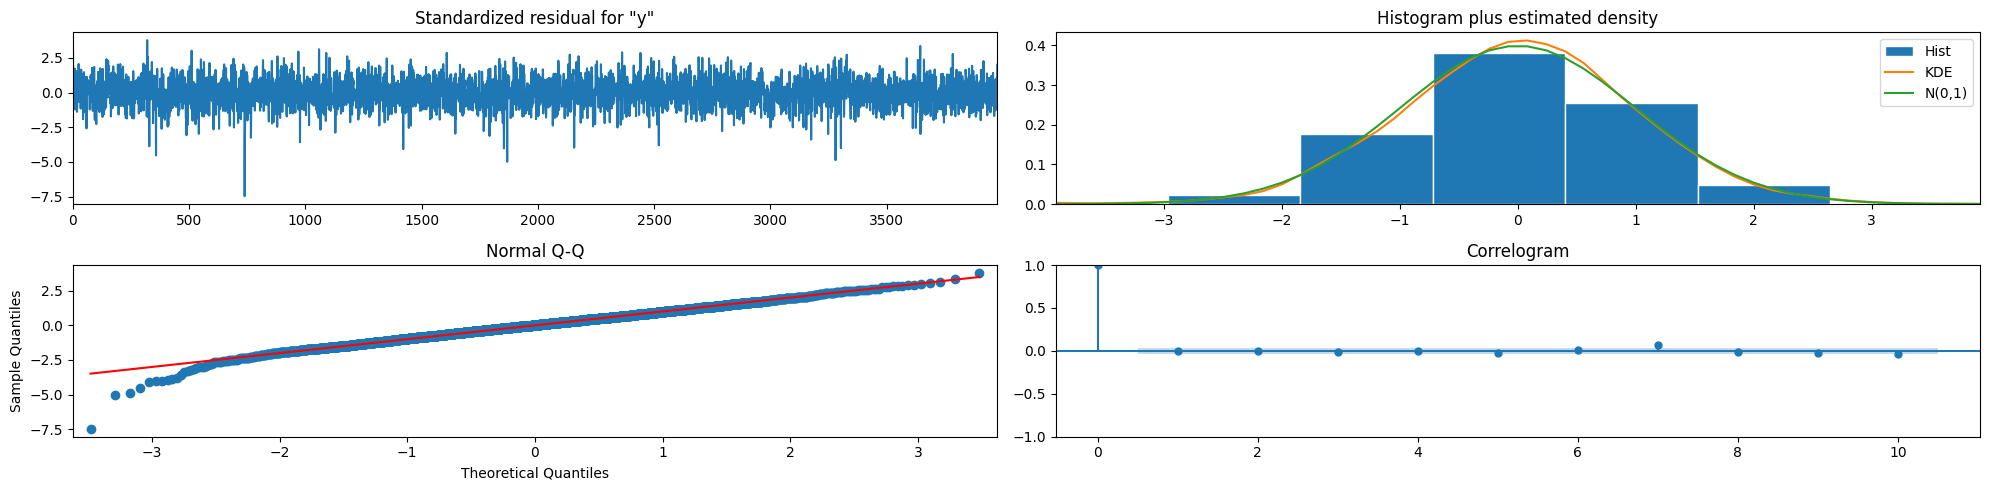

In [ ]:
fitted_model.plot_diagnostics(0,figsize=(20,5))
plt.plot()
plt.tight_layout()

Text(0, 0.5, 'Gęstość')

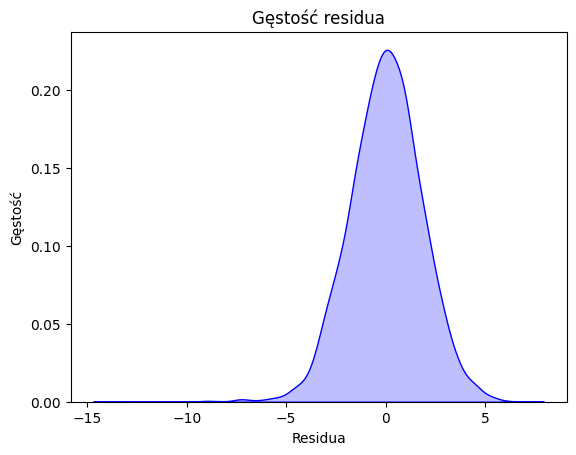

In [162]:
# 1. Gęstość
sns.kdeplot(residua, color='b', fill=True)
plt.title('Gęstość residua')
plt.xlabel('Residua')
plt.ylabel('Gęstość')


Text(0, 0.5, 'Gęstość')

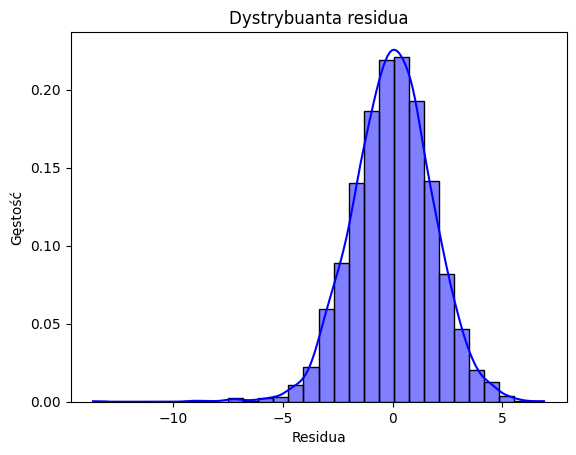

In [163]:
# 2. Dystrybuanta
sns.histplot(residua, bins=30, stat='density', kde=True, color='b', edgecolor='black', fill=True)
plt.title('Dystrybuanta residua')
plt.xlabel('Residua')
plt.ylabel('Gęstość')

Text(0.5, 1.0, 'Wykres kwantylowy residua')

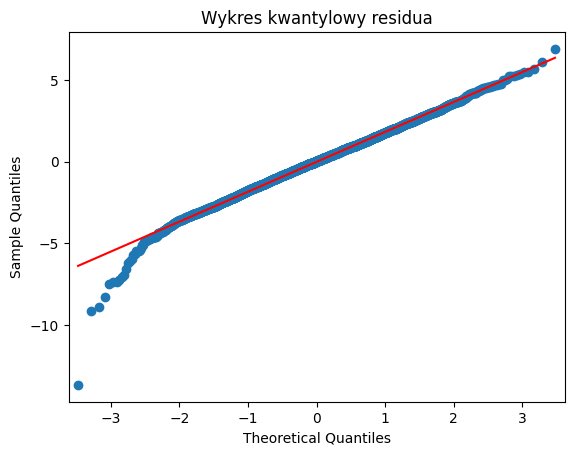

In [164]:
# 3. Wykres kwantylowy
sm.qqplot(residua, line='s', ax=plt.gca())
plt.title('Wykres kwantylowy residua')


Odrzucamy hipotezę zerową - residua nie są normalnie rozłożone.


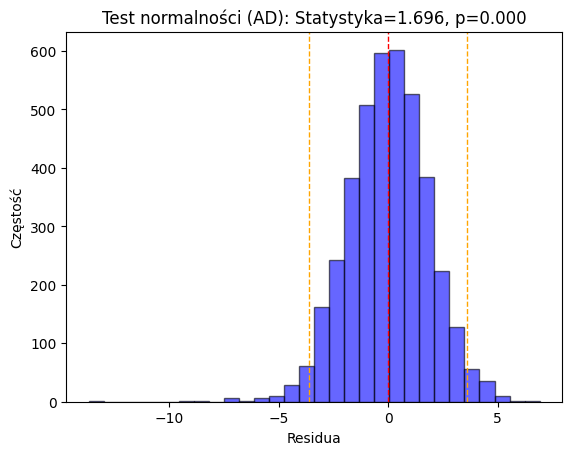

In [165]:
# 4. Testowanie na normalność
stat, p_value = normal_ad(residua)
plt.hist(residua, bins=30, color='b', alpha=0.6, edgecolor='black')
plt.axvline(np.mean(residua), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(residua) + 1.96 * np.std(residua), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(residua) - 1.96 * np.std(residua), color='orange', linestyle='dashed', linewidth=1)
plt.title(f'Test normalności (AD): Statystyka={stat:.3f}, p={p_value:.3f}')
plt.xlabel('Residua')
plt.ylabel('Częstość')

# Interpretacja wyników testu
alpha = 0.05
if p_value < alpha:
    print("Odrzucamy hipotezę zerową - residua nie są normalnie rozłożone.")
else:
    print("Nie odrzucamy hipotezy zerowej - residua są normalnie rozłożone.")

In [179]:
# 3. Dopasowanie rozkładu t-Studenta
# Dopasowanie parametrów rozkładu t-Studenta (df, loc, scale)
df, loc, scale = stats.t.fit(residua)

# 5. Test Kolmogorova-Smirnova
ks_stat, ks_p_value = stats.kstest(residua, 't', args=(df, loc, scale))
print(f"\nTest Kolmogorova-Smirnova (zgodność z t-Studentem): statystyka = {ks_stat:.4f}, p-wartość = {ks_p_value:.4f}")
if ks_p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy o zgodności z rozkładem t-Studenta (na poziomie 5%).")
else:
    print("Odrzucono hipotezę o zgodności z rozkładem t-Studenta (na poziomie 5%).")



Test Kolmogorova-Smirnova (zgodność z t-Studentem): statystyka = 0.0092, p-wartość = 0.8864
Brak podstaw do odrzucenia hipotezy o zgodności z rozkładem t-Studenta (na poziomie 5%).


In [181]:
from scipy.stats import cramervonmises
# Funkcja dystrybuanty teoretycznej dla rozkładu t-Studenta
def cdf_t(x):
    return stats.t.cdf(x, df, loc, scale)

# Test Craméra-von Misesa
cvm_result = cramervonmises(residua, cdf_t)

# Wyświetlanie wyników
print(f"Statystyka testu Craméra-von Misesa: {cvm_result.statistic:.4f}")
print(f"P-wartość: {cvm_result.pvalue:.4f}")

if cvm_result.pvalue > 0.05:
    print("Brak podstaw do odrzucenia hipotezy, że dane pochodzą z rozkładu t-Studenta.")
else:
    print("Odrzucono hipotezę, że dane pochodzą z rozkładu t-Studenta.")

Statystyka testu Craméra-von Misesa: 0.0582
P-wartość: 0.8251
Brak podstaw do odrzucenia hipotezy, że dane pochodzą z rozkładu t-Studenta.


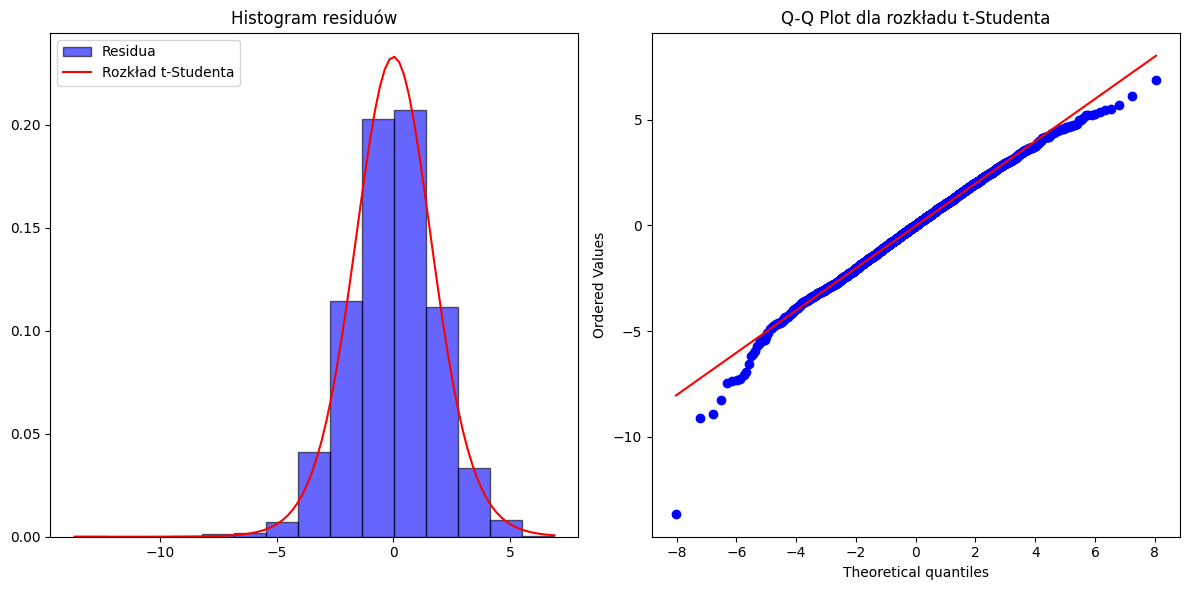

In [183]:
# Wizualizacja: Histogram i Q-Q Plot
plt.figure(figsize=(12, 6))

# Histogram residuów
plt.subplot(1, 2, 1)
plt.hist(residua, bins=15, density=True, color='b', alpha=0.6, edgecolor='black', label="Residua")
x = np.linspace(min(residua), max(residua), 100)
pdf_t = stats.t.pdf(x, df, loc, scale)  # Gęstość teoretyczna t-Studenta
plt.plot(x, pdf_t, 'r-', label="Rozkład t-Studenta")
plt.title("Histogram residuów")
plt.legend()

# Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(residua, dist="t", sparams=(df, loc, scale), plot=plt)
plt.title("Q-Q Plot dla rozkładu t-Studenta")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Boxplot residuów')

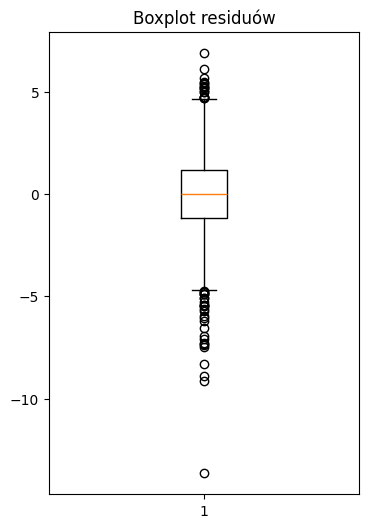

In [104]:
plt.figure(figsize = (4,6))
plt.boxplot(residua)
plt.title("Boxplot residuów")

# PACF i ACF residułów

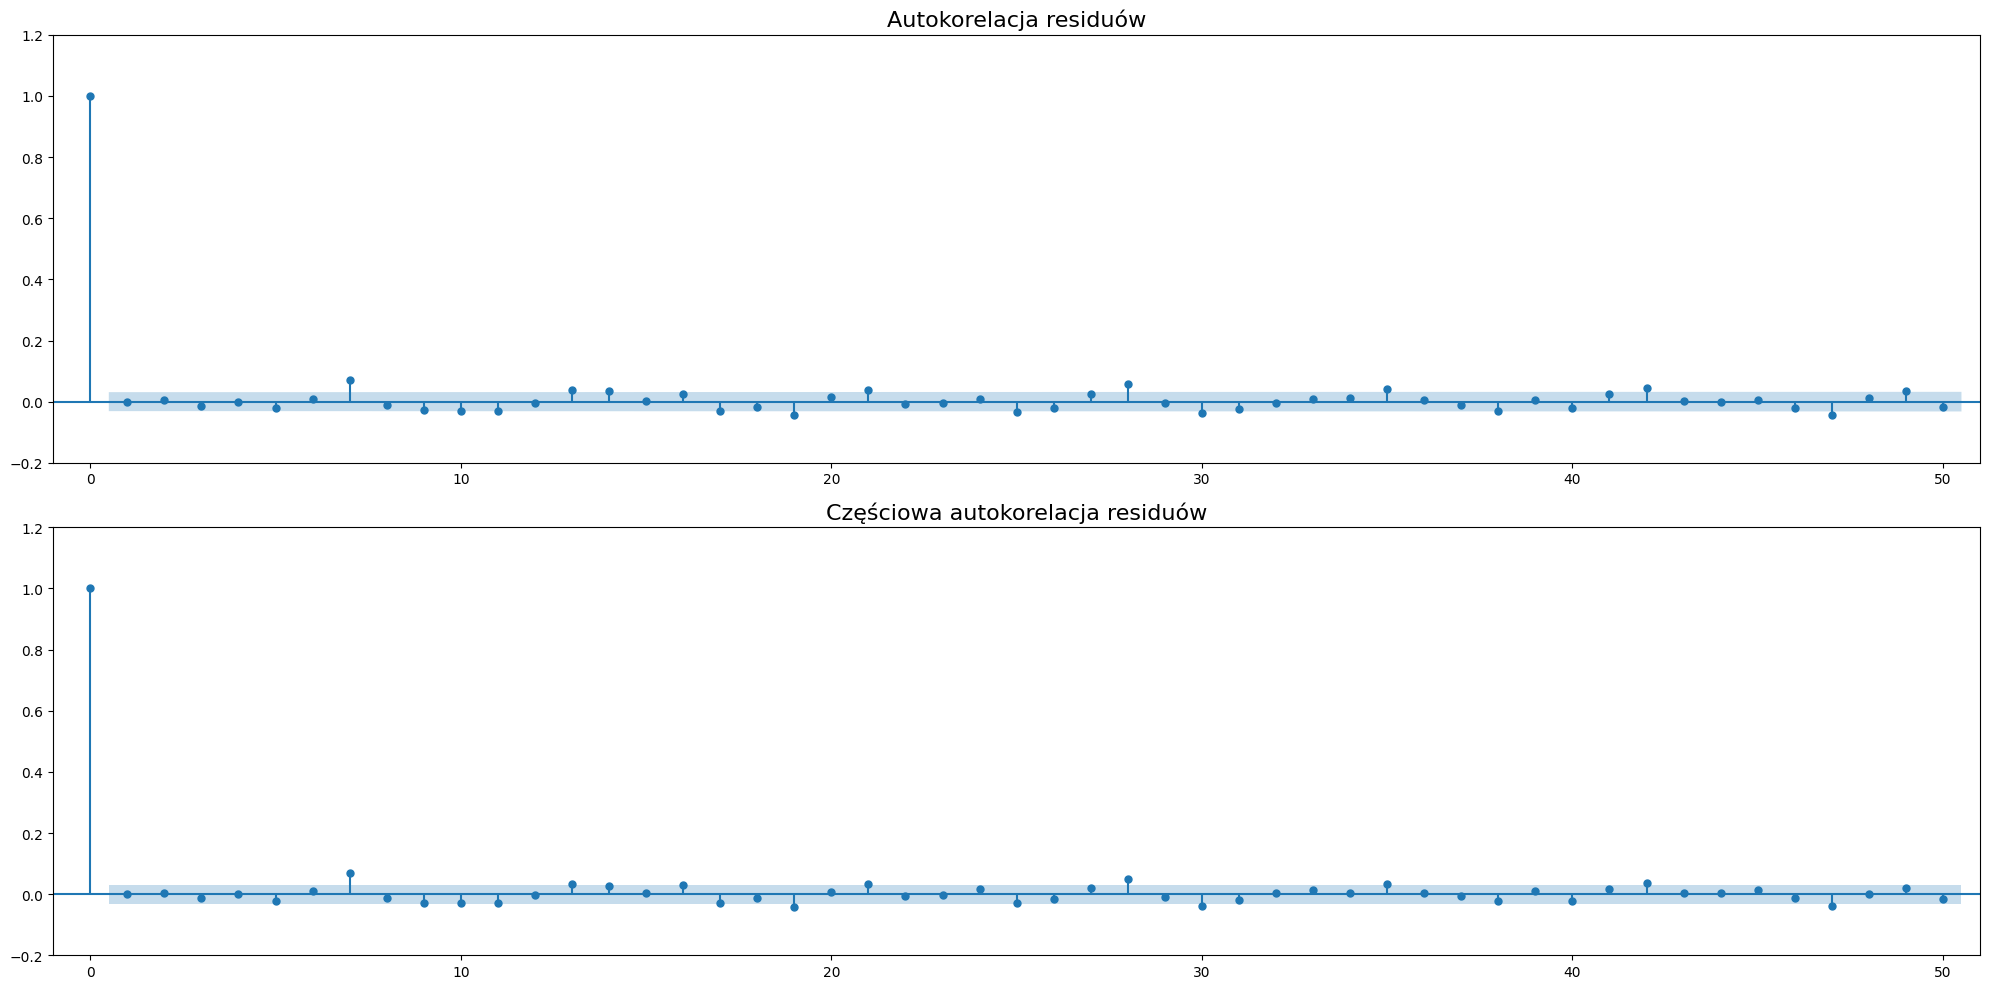

In [173]:
h = 50
plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plot_acf(residua, lags=h, adjusted=True, ax=plt.gca())
plt.ylim((-0.2,1.2))
plt.xlim((-1,51))
plt.title("Autokorelacja residuów", fontsize = 16)

plt.subplot(2, 1, 2)
plot_pacf(residua, lags=h, method='ywm', ax=plt.gca())
plt.ylim((-0.2,1.2))
plt.xlim((-1,51))
plt.title("Częściowa autokorelacja residuów", fontsize = 16)

plt.tight_layout()
plt.show()
